In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import planarity
from qplanarity import load_planar_graphs, generate_graphs, observable, get_trained_model, predict, analyse_pred
from tqdm.notebook import tqdm
from operator import itemgetter
from utils import Memoizer
import pandas as pd

Using backend: pytorch
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Planarity module

In [3]:
# Example of the complete graph of 5 nodes, K5
# K5 is not planar
edgelist = [('a', 'b'), ('a', 'c'), ('a', 'd'), ('a', 'e'),
            ('b', 'c'),('b', 'd'),('b', 'e'),
            ('c', 'd'), ('c', 'e'),
            ('d', 'e')]

print(planarity.is_planar(edgelist))

# remove an edge to make the graph planar
edgelist.remove(('a','b'))
print(planarity.is_planar(edgelist))

# make an ascii text drawing
print(planarity.ascii(edgelist))

False
True
----1----
|  |    |
|  --5--|
|   || ||
--4--| ||
 ||  | ||
 |--3--||
 |    |||
 ---2----
         



## Planar graphs

In [4]:
%%time
n = 7 # 9 takes 2s already
graphs = load_planar_graphs(n)
print(len(graphs))
sorted(graphs[0].edges())

646
CPU times: user 15.1 ms, sys: 1.46 ms, total: 16.6 ms
Wall time: 16.4 ms


[(0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6)]

In [5]:
%%time
planars = 0
for graph in tqdm(graphs):
    planars += planarity.is_planar(graph)
assert planars == len(graphs)

  0%|          | 0/646 [00:00<?, ?it/s]

CPU times: user 26.1 ms, sys: 11.3 ms, total: 37.3 ms
Wall time: 37.4 ms


## Tests for development of key getter function for Memoizer

In [6]:
edges = list(map(sorted, graphs[1].edges()))
k1, k2 = tuple(map(tuple, sorted(edges, key=itemgetter(0,1)))), tuple(graphs[1].edges())
d = {}
d[k1] = 'test'  # can be used as key
k1, k2

(((0, 6), (1, 6), (2, 6), (3, 6), (4, 5), (4, 6), (5, 6)),
 ((0, 6), (1, 6), (2, 6), (3, 6), (4, 5), (4, 6), (5, 6)))

## Graph generator

In [7]:
import numpy as np
from tqdm.notebook import trange
import matplotlib.pyplot as plt

from utils import return_list_of_states, return_energy_distribution, return_js_matrix, return_js_dist_matrix, entropy, merge_energies
from qutip import mcsolve, sesolve, sigmaz, sigmap, qeye, tensor, Options, expect, sigmam
from data_preprocessing import load_dataset
import pickle
import networkx as nx
import grakel
from time import time

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV
from skopt import gp_minimize

In [8]:
np.random.seed(21)
graphs, targets = generate_graphs(range(3, 11), 2 * [50] + 3 * [100] + 3 * [200], generator='binomial', verbose=True)
graphs[:5], targets[:5]

0it [00:00, ?it/s]

Generated graphs with   3 nodes are at 100.0% planar in average
Generated graphs with   4 nodes are at 100.0% planar in average
Generated graphs with   5 nodes are at  72.0% planar in average
Generated graphs with   6 nodes are at  64.0% planar in average
Generated graphs with   7 nodes are at  50.0% planar in average
Generated graphs with   8 nodes are at  64.0% planar in average
Generated graphs with   9 nodes are at  53.5% planar in average
Generated graphs with  10 nodes are at  46.5% planar in average
Generated graphs are at  61.4% planar in average


([<networkx.classes.graph.Graph at 0x110505160>,
 [True, True, True, True, True])

In [9]:
# graphs, targets = generate_graphs(7, 18)
# graphs[:5], targets[:5]

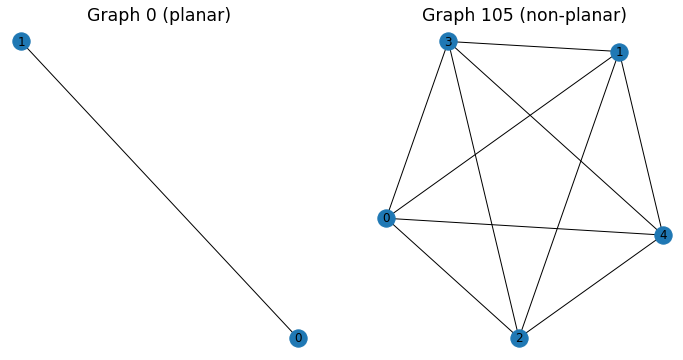

In [10]:
plt.figure(figsize=[12,6])
plt.subplot(121)
i_planar = targets.index(1)
nx.draw(graphs[i_planar], with_labels=True)
plt.title(f"Graph {i_planar} (planar)", fontsize='xx-large')
plt.subplot(122)
i_non_planar = targets.index(0)
nx.draw(graphs[i_non_planar], with_labels=True)
plt.title(f"Graph {i_non_planar} (non-planar)", fontsize='xx-large')
plt.show()

In [11]:
graphs[1].edges

EdgeView([(0, 1)])

## Generate the hamiltonian evolutions

We describe here how to perform a graph classification for specific values of times and pulses for a 2 layers ising evolution.

Generate the final states of all graphs 

In [12]:
times = [2.1, 1.6]
pulses = [0.2, 0.1]

states = return_list_of_states(graphs, times, pulses, evol='ising', verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Plot some final states after evolution

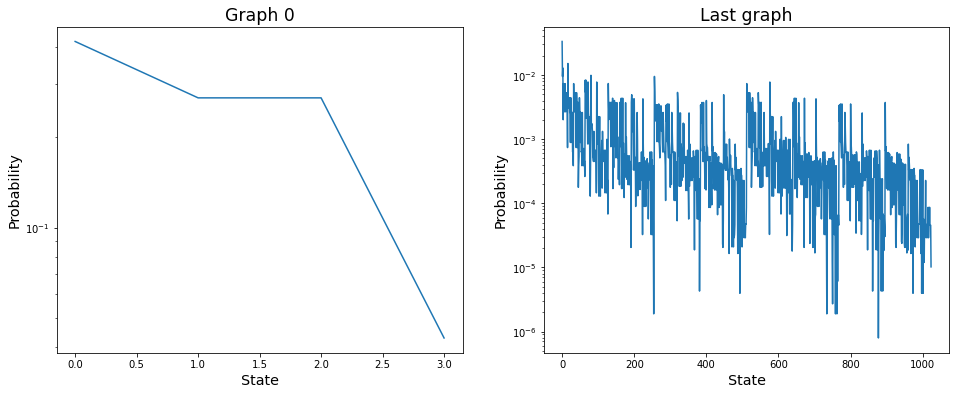

In [13]:
plt.figure(figsize=[16,6])
plt.subplot(121)
prob = np.abs(states[0].data.toarray())**2
plt.plot(prob)
plt.yscale('log')
plt.xlabel('State', fontsize='x-large')
plt.ylabel('Probability', fontsize='x-large')
plt.title("Graph 0", fontsize='xx-large')
plt.subplot(122)
prob = np.abs(states[-1].data.toarray())**2
plt.plot(prob)
plt.yscale('log')
plt.xlabel('State', fontsize='x-large')
plt.ylabel('Probability', fontsize='x-large')
plt.title("Last graph", fontsize='xx-large')
plt.show()

Compute the probability distribution of the Ising observable from each state.

In [14]:
observables_memoizer = Memoizer(observable)

Compute the probability distribution and the distance matrix

In [15]:
energies_masses, energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable, verbose=True, return_energies=True)
matrix = return_js_matrix(energies_masses)

  0%|          | 0/1000 [00:00<?, ?it/s]

Fit the model

In [16]:
K = np.exp(-matrix)
C_list = np.logspace(-3, 3, 7)

param_grid = {'C': C_list}
scoring = {'accuracy': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score, average='weighted')
            }

skf = RepeatedStratifiedKFold(10, 10, random_state=47)

estimator = svm.SVC(kernel='precomputed', random_state=76)

grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                cv=skf, refit='accuracy', n_jobs=-1)
result = grid_search.fit(K, targets).cv_results_

i_best = np.argmax(result['mean_test_accuracy'])
print('Accuracy: ', result['mean_test_accuracy'][i_best], '±', result['std_test_accuracy'][i_best])


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy:  0.9975 ± 0.005722761571129804


5

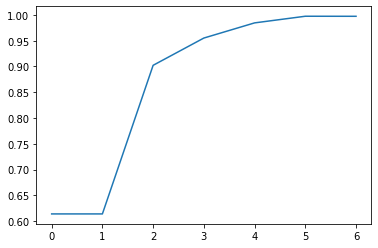

In [17]:
plt.plot(result['mean_test_accuracy'])
i_best

## Investigate generalisation capabilities

In [18]:
def tester(model, graphs, targets, energies_masses, energies):  
    times = [2.1, 1.6]
    pulses = [0.2, 0.1]

    states = return_list_of_states(graphs, times, pulses, evol='ising', verbose=1)
    _energies_masses, _energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable, return_energies=True, verbose=True)
    print(energies_masses.shape, _energies_masses.shape)
    energies_masses, _energies_masses = merge_energies(energies_masses, energies, _energies_masses, _energies)
    print(energies_masses.shape, _energies_masses.shape)
    print(energies.shape, _energies.shape)
    print(energies)
    # Should build correct test kernel | Ref.: https://stats.stackexchange.com/a/96881
    matrix = return_js_dist_matrix(_energies_masses, energies_masses, verbose=True)
    K = np.exp(-matrix)

    return model.predict(K), targets, model.score(K, targets)

In [19]:
merge_energies(np.array([[1, 2], [1, 2]]), [1, 2], np.array([[-1], [-1]]), [-1])

(array([[0., 1., 2.],
        [0., 1., 2.]]),
 array([[-1.,  0.,  0.],
        [-1.,  0.,  0.]]))

In [20]:
tester(grid_search, graphs, targets, energies_masses, energies)[2]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 54)
(1000, 54) (1000, 54)
(54,) (54,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

0.999

In [21]:
test_graphs, test_targets = generate_graphs([13], [10], generator='binomial')
test_graphs[:5], test_targets[:5]

([<networkx.classes.graph.Graph at 0x168e64b50>,
 [True, False, False, False, True])

In [22]:
tester(grid_search, test_graphs, test_targets, energies_masses, energies)[2]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(1000, 54) (10, 58)
(1000, 66) (10, 66)
(54,) (58,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/10 [00:00<?, ?it/s]

0.9

In [23]:
scores = []
ns = range(3, 8)
for n in ns:
    test_graphs, test_targets = generate_graphs([n], [1000], generator='binomial')
    y_pred, y_true, score = tester(grid_search, test_graphs, test_targets, energies_masses, energies)
    print(confusion_matrix(y_true, y_pred))
    print(f"\t### SCORE OF {score} FOR {n} NODES ###")
    scores.append(score)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 6)
(1000, 54) (1000, 54)
(54,) (6,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[1000]]
	### SCORE OF 1.0 FOR 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 10)
(1000, 54) (1000, 54)
(54,) (10,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[1000]]
	### SCORE OF 1.0 FOR 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 16)
(1000, 54) (1000, 54)
(54,) (16,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[220   0]
 [  0 780]]
	### SCORE OF 1.0 FOR 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 22)
(1000, 54) (1000, 54)
(54,) (22,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[319   0]
 [  0 681]]
	### SCORE OF 1.0 FOR 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 31)
(1000, 54) (1000, 54)
(54,) (31,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[488   5]
 [  0 507]]
	### SCORE OF 0.995 FOR 7 NODES ###


Text(0.5, 0, 'Number of nodes')

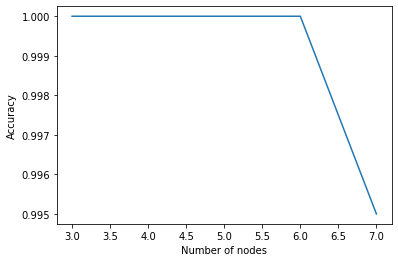

In [24]:
plt.plot(ns, scores)
plt.ylabel('Accuracy')
plt.xlabel('Number of nodes')

In [25]:
planar_graphs = nx.read_graph6(f'datasets/planar_conn.{7}.g6')[:100]
tester(grid_search, planar_graphs, [1] * len(planar_graphs), energies_masses, energies)[2]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(1000, 54) (100, 24)
(1000, 54) (100, 54)
(54,) (24,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/100 [00:00<?, ?it/s]

0.92

## Find the best parameters

Now we look for the values of times and pulses to get the best accuracy score. This is done by bayesian optimization.

Define the score function

In [26]:
def get_score(param):
    middle = len(param)//2
    states = return_list_of_states(graphs, param[0:middle], param[middle::], evol='ising')
    energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable)
    matrix = return_js_matrix(energies)
    K = np.exp(-matrix)
    C_list = np.logspace(-3, 3, 7)

    param_grid = {'C': C_list}
    scoring = {'accuracy': make_scorer(accuracy_score),
                'f1_score': make_scorer(f1_score, average='weighted')
                }

    skf = RepeatedStratifiedKFold(10, 10, random_state=47)
    # skf = StratifiedKFold(5, shuffle=True, random_state=47)

    estimator = svm.SVC(kernel='precomputed', random_state=76)

    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                    cv=skf, refit=False, n_jobs=-1)
    result = grid_search.fit(K, targets).cv_results_

    return -np.max(result['mean_test_accuracy'])
    


Run the bayesian optimization (can take up to 15 min)

In [27]:
bounds = [(0., 3.)] * 2 + [(0., 1.)] * 2
    
opt_result = gp_minimize(
    get_score,
    bounds,
    acq_func='LCB',
    n_calls=30,
    n_initial_points=20,
    acq_optimizer='sampling',
    n_points=5000,
    kappa=4,
    n_jobs=-1,
    verbose=True)

Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 24.4644
Function value obtained: -0.9982
Current minimum: -0.9982
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 25.3313
Function value obtained: -0.9970
Current minimum: -0.9982
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 23.9739
Function value obtained: -0.9976
Current minimum: -0.9982
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 24.8756
Function value obtained: -0.9974
Current minimum: -0.9982
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 24.9410
Function value obtained: -0.9978
Current minimum: -0.9982
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 24.2763
Function value obtained: -0.9988
Current minimum: -0.9988
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 25.6776
Function value obtained: -0.9980
Current minimum: -0.9988
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 25.4148
Function value obtained: -0.9986
Current minimum: -0.9988
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 24.6598
Function value obtained: -0.9967
Current minimum: -0.9988
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 24.4488
Function value obtained: -0.9978
Current minimum: -0.9988
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 25.4010
Function value obtained: -0.9990
Current minimum: -0.9990
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 24.7986
Function value obtained: -0.9965
Current minimum: -0.9990
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 25.2790
Function value obtained: -0.9968
Current minimum: -0.9990
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 24.3663
Function value obtained: -0.9977
Current minimum: -0.9990
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 24.8039
Function value obtained: -0.9978
Current minimum: -0.9990
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 24.1070
Function value obtained: -0.9969
Current minimum: -0.9990
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 24.4226
Function value obtained: -0.9978
Current minimum: -0.9990
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 24.6561
Function value obtained: -0.9980
Current minimum: -0.9990
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 24.5116
Function value obtained: -0.9963
Current minimum: -0.9990
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 25.7986
Function value obtained: -0.9974
Current minimum: -0.9990
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 25.4562
Function value obtained: -0.9984
Current minimum: -0.9990
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 26.1670
Function value obtained: -0.9975
Current minimum: -0.9990
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 25.9196
Function value obtained: -0.9976
Current minimum: -0.9990
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 24.7869
Function value obtained: -0.9986
Current minimum: -0.9990
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 25.6673
Function value obtained: -0.9979
Current minimum: -0.9990
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 25.3340
Function value obtained: -0.9985
Current minimum: -0.9990
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 25.9732
Function value obtained: -0.9984
Current minimum: -0.9990
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 25.7441
Function value obtained: -0.9978
Current minimum: -0.9990
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 24.5401
Function value obtained: -0.9980
Current minimum: -0.9990
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 24.9106
Function value obtained: -0.9982
Current minimum: -0.9990


In [28]:
i_best = np.argmin(opt_result.func_vals)
print('Best accuracy: ', np.abs(opt_result.func_vals[i_best]))
print('Best parameters: ', opt_result.x_iters[i_best])

Best accuracy:  0.9989999999999999
Best parameters:  [1.3477293073265297, 0.4309718986961554, 0.9561314630934645, 0.7419091497350414]


# Scalability test

In [29]:
# > opt_result.x_iters[i_best]
# [1.3120541742020804, 1.1183939472347362, 0.6069423321714197, 0.774875787317455]
times = opt_result.x_iters[i_best][:2]
pulses = opt_result.x_iters[i_best][2:]


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   3 nodes are at 100.0% planar in average
Generated graphs with   4 nodes are at 100.0% planar in average
Generated graphs with   5 nodes are at  72.0% planar in average
Generated graphs with   6 nodes are at  64.0% planar in average
Generated graphs with   7 nodes are at  50.0% planar in average
Generated graphs with   8 nodes are at  64.0% planar in average
Generated graphs with   9 nodes are at  53.5% planar in average
Generated graphs with  10 nodes are at  46.5% planar in average
Generated graphs are at  61.4% planar in average

	# 2. Train model



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 99.900% ± 0.300% for C=1000.0


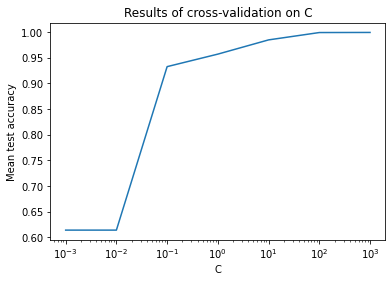

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[386   0]
 [  0 614]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       386
      Planar       1.00      1.00      1.00       614

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	# 4. Investigate generalisation capabilities


	#   a. 10 graphs of 20 nodes



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/10 [00:00<?, ?it/s]

[[8 1]
 [0 1]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.89      0.94         9
      Planar       0.50      1.00      0.67         1

    accuracy                           0.90        10
   macro avg       0.75      0.94      0.80        10
weighted avg       0.95      0.90      0.91        10


	### Score: 90.00% (precision for planar: 0.500 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[218   0]
 [  0 782]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       218
      Planar       1.00      1.00      1.00       782

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[319   0]
 [  0 681]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       319
      Planar       1.00      1.00      1.00       681

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[489   0]
 [  5 506]]
              precision    recall  f1-score   support

  Non-planar       0.99      1.00      0.99       489
      Planar       1.00      0.99      1.00       511

    accuracy                           0.99      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       1.00      0.99      1.00      1000


	### Score: 99.50% (precision for planar: 1.000 & non-planar: 0.990)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[445   0]
 [  0 555]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       445
      Planar       1.00      1.00      1.00       555

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[454   0]
 [  0 546]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       454
      Planar       1.00      1.00      1.00       546

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[537   0]
 [  0 463]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       537
      Planar       1.00      1.00      1.00       463

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[538  17]
 [ 32 413]]
              precision    recall  f1-score   support

  Non-planar       0.94      0.97      0.96       555
      Planar       0.96      0.93      0.94       445

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 95.10% (precision for planar: 0.960 & non-planar: 0.944)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[585   0]
 [ 11 404]]
              precision    recall  f1-score   support

  Non-planar       0.98      1.00      0.99       585
      Planar       1.00      0.97      0.99       415

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 98.90% (precision for planar: 1.000 & non-planar: 0.982)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[590  11]
 [ 28 371]]
              precision    recall  f1-score   support

  Non-planar       0.95      0.98      0.97       601
      Planar       0.97      0.93      0.95       399

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 96.10% (precision for planar: 0.971 & non-planar: 0.955)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[632   0]
 [ 55 313]]
              precision    recall  f1-score   support

  Non-planar       0.92      1.00      0.96       632
      Planar       1.00      0.85      0.92       368

    accuracy                           0.94      1000
   macro avg       0.96      0.93      0.94      1000
weighted avg       0.95      0.94      0.94      1000


	### Score: 94.50% (precision for planar: 1.000 & non-planar: 0.920)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[612   0]
 [ 77 311]]
              precision    recall  f1-score   support

  Non-planar       0.89      1.00      0.94       612
      Planar       1.00      0.80      0.89       388

    accuracy                           0.92      1000
   macro avg       0.94      0.90      0.92      1000
weighted avg       0.93      0.92      0.92      1000


	### Score: 92.30% (precision for planar: 1.000 & non-planar: 0.888)

	### 16 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[641   0]
 [111 248]]
              precision    recall  f1-score   support

  Non-planar       0.85      1.00      0.92       641
      Planar       1.00      0.69      0.82       359

    accuracy                           0.89      1000
   macro avg       0.93      0.85      0.87      1000
weighted avg       0.91      0.89      0.88      1000


	### Score: 88.90% (precision for planar: 1.000 & non-planar: 0.852)

	### 17 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[765  17]
 [ 34 184]]
              precision    recall  f1-score   support

  Non-planar       0.96      0.98      0.97       782
      Planar       0.92      0.84      0.88       218

    accuracy                           0.95      1000
   macro avg       0.94      0.91      0.92      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 94.90% (precision for planar: 0.915 & non-planar: 0.957)

	### 18 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[778  44]
 [ 37 141]]
              precision    recall  f1-score   support

  Non-planar       0.95      0.95      0.95       822
      Planar       0.76      0.79      0.78       178

    accuracy                           0.92      1000
   macro avg       0.86      0.87      0.86      1000
weighted avg       0.92      0.92      0.92      1000


	### Score: 91.90% (precision for planar: 0.762 & non-planar: 0.955)


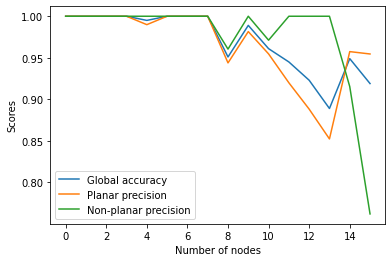

[(1.0, 1, 1),
 (1.0, 1, 1),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 1.0),
 (0.995, 0.9898785425101214, 1.0),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 1.0),
 (0.951, 0.9438596491228071, 0.9604651162790697),
 (0.989, 0.9815436241610739, 1.0),
 (0.961, 0.9546925566343042, 0.9712041884816754),
 (0.945, 0.9199417758369723, 1.0),
 (0.923, 0.888243831640058, 1.0),
 (0.889, 0.8523936170212766, 1.0),
 (0.949, 0.9574468085106383, 0.9154228855721394),
 (0.919, 0.9546012269938651, 0.7621621621621621)]

In [30]:
from qplanarity import test_suite

# times = [2.1, 1.6]
# pulses = [0.2, 0.1]
train_ns = range(3, 11)
train_nbs = 2 * [50] + 3 * [100] + 3 * [200]
generator = 'binomial'

test_suite(times, pulses, train_ns, train_nbs, generator, seed=21)

In [31]:
times_taken = [0, 0, 0, 4, 6, 7, 8, 10, 12, 15, 22, 36, 63, 115, 223, 506]

In [32]:
def time_required(n_max):
    assert n_max >= 11, 'Useless for small number of nodes'
    low = 10 * 5 # 3 to 7
    med = 30 * 4 # 8 to 11
    high = 32 * 2**(n_max - 11 + 1) # + 1 as it is the sum of all the powers of 2 below
    tot = low + med + high
    print(f"{tot}s = {tot / 60:.2f}m = {tot/3600:.2f}h")
    return tot

In [33]:
time_required(len(times_taken) - 1), sum(times_taken)

1194s = 19.90m = 0.33h


(1194, 1027)

In [34]:
time_required(18)

8362s = 139.37m = 2.32h


8362

# Scalability optimisation test

  0%|          | 0/11 [00:00<?, ?it/s]


	### 5 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.8264
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.2734
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.1853
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.0979
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.1331
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 2.1365
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 2.0574
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 2.1104
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 2.0964
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 2.0698
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 2.1035
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 2.1348
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 2.0660
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 2.2726
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 2.1498
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 2.1122
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 2.0884
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 2.0598
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 2.1310
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 2.2029
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 2.1870
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 2.2037
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.2207
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 2.2414
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 2.1513
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.2477
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 2.2860
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.2180
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 2.3227
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 2.2554
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [2.198561153646045, 0.014684713036138278] and pulses [0.8901955852106084, 0.6384686361728018]


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=1.0


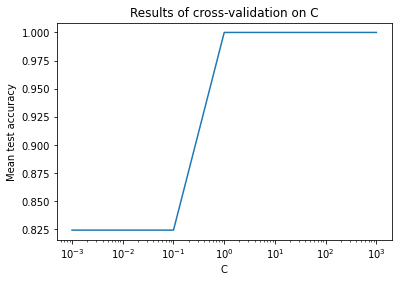

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/340 [00:00<?, ?it/s]

[[  2 191]
 [  0 147]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.01      0.02       193
      Planar       0.43      1.00      0.61       147

    accuracy                           0.44       340
   macro avg       0.72      0.51      0.31       340
weighted avg       0.76      0.44      0.27       340


	### Score: 43.82% (precision for planar: 0.435 & non-planar: 1.000)

	### 6 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.2661
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.6537
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.4401
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.6737
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.4540
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 3.3537
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 3.2252
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 3.2165
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 3.1610
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.2167
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 3.2498
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 3.1923
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 3.1324
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 3.1297
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 3.5134
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 3.2852
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 3.2398
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 3.2428
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 3.2259
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 3.3926
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 3.4201
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 3.4485
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 3.3855
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 3.4092
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 3.4861
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.4497
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 3.4421
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.5364
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 3.4561
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.4822
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [2.4676397225495412, 2.96293795924532] and pulses [0.3864894847756092, 0.5797149716685726]


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=10.0


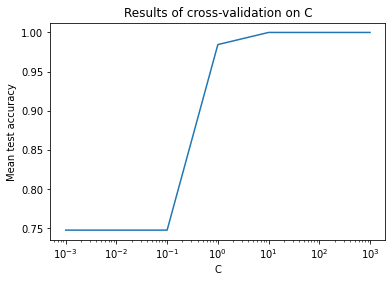

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/340 [00:00<?, ?it/s]

[[174  19]
 [ 18 129]]
              precision    recall  f1-score   support

  Non-planar       0.91      0.90      0.90       193
      Planar       0.87      0.88      0.87       147

    accuracy                           0.89       340
   macro avg       0.89      0.89      0.89       340
weighted avg       0.89      0.89      0.89       340


	### Score: 89.12% (precision for planar: 0.872 & non-planar: 0.906)

	### 7 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.0599
Function value obtained: -0.9958
Current minimum: -0.9958
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.9474
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.8762
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.9046
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.9062
Function value obtained: -0.9958
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 2.8804
Function value obtained: -0.9958
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 3.0079
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 2.9300
Function value obtained: -0.9958
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 2.9677
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 2.9935
Function value obtained: -0.9921
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 3.0155
Function value obtained: -0.9917
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 3.1007
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 3.0522
Function value obtained: -0.9958
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 3.1745
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 3.1722
Function value obtained: -0.9958
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 3.2674
Function value obtained: -0.9958
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 3.2996
Function value obtained: -0.9917
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 3.2951
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 3.2487
Function value obtained: -0.9958
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 3.5362
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 3.4399
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 3.4012
Function value obtained: -0.9958
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 3.5266
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 3.5478
Function value obtained: -0.9962
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 3.5007
Function value obtained: -0.9958
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.8184
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 3.6144
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.5326
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 3.6921
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.5689
Function value obtained: -0.9962
Current minimum: -1.0000
Score 100.0% obtained for times [0.4899817138330954, 1.4829579881753834] and pulses [0.9541907444713732, 0.4128271207320323]


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=10.0


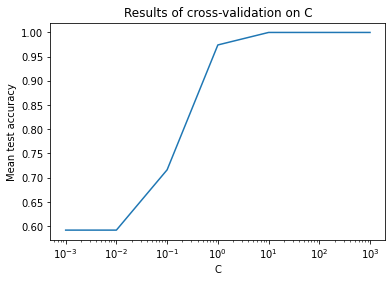

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/340 [00:00<?, ?it/s]

[[193   0]
 [ 21 126]]
              precision    recall  f1-score   support

  Non-planar       0.90      1.00      0.95       193
      Planar       1.00      0.86      0.92       147

    accuracy                           0.94       340
   macro avg       0.95      0.93      0.94       340
weighted avg       0.94      0.94      0.94       340


	### Score: 93.82% (precision for planar: 1.000 & non-planar: 0.902)

	### 8 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.9591
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.5839
Function value obtained: -0.9978
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.6617
Function value obtained: -0.9913
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.6074
Function value obtained: -0.9989
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.6117
Function value obtained: -0.9967
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 3.6144
Function value obtained: -0.9898
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 3.5702
Function value obtained: -0.9945
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 3.5933
Function value obtained: -0.9945
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 3.5795
Function value obtained: -0.9945
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.6185
Function value obtained: -0.9945
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 3.6353
Function value obtained: -0.9945
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 3.6137
Function value obtained: -0.9945
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 3.5638
Function value obtained: -0.9836
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 3.6144
Function value obtained: -0.9989
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 3.6470
Function value obtained: -0.9938
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 3.5975
Function value obtained: -0.9908
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 3.5749
Function value obtained: -0.9935
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 3.6006
Function value obtained: -0.9989
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 3.5955
Function value obtained: -0.9945
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 3.7794
Function value obtained: -0.9853
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 3.6223
Function value obtained: -0.9967
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 3.6509
Function value obtained: -0.9901
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 3.6369
Function value obtained: -0.9967
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 3.6887
Function value obtained: -0.9945
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 3.7989
Function value obtained: -0.9912
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.8095
Function value obtained: -0.9945
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 3.7547
Function value obtained: -0.9945
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.6200
Function value obtained: -0.9982
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 3.8147
Function value obtained: -0.9945
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.6912
Function value obtained: -0.9927
Current minimum: -1.0000
Score 100.0% obtained for times [0.5771129615199415, 2.292142200134563] and pulses [0.22383522720465193, 0.23463742707343488]


  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=100.0


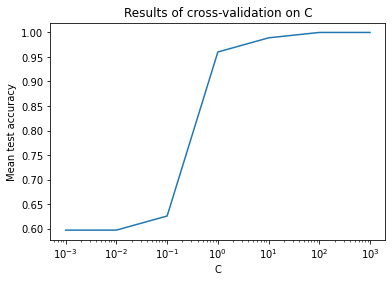

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/340 [00:00<?, ?it/s]

[[126  67]
 [  0 147]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.65      0.79       193
      Planar       0.69      1.00      0.81       147

    accuracy                           0.80       340
   macro avg       0.84      0.83      0.80       340
weighted avg       0.86      0.80      0.80       340


	### Score: 80.29% (precision for planar: 0.687 & non-planar: 1.000)

	### 9 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.9936
Function value obtained: -0.9799
Current minimum: -0.9799
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.3261
Function value obtained: -0.9836
Current minimum: -0.9836
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.3936
Function value obtained: -0.9846
Current minimum: -0.9846
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.3960
Function value obtained: -0.9786
Current minimum: -0.9846
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.3104
Function value obtained: -0.9896
Current minimum: -0.9896
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 4.3629
Function value obtained: -0.9849
Current minimum: -0.9896
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 4.3004
Function value obtained: -0.9833
Current minimum: -0.9896
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.3223
Function value obtained: -0.9859
Current minimum: -0.9896
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 4.3167
Function value obtained: -0.9893
Current minimum: -0.9896
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 4.3617
Function value obtained: -0.9933
Current minimum: -0.9933
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 4.3822
Function value obtained: -0.9806
Current minimum: -0.9933
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 4.3711
Function value obtained: -0.9879
Current minimum: -0.9933
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 4.2661
Function value obtained: -0.9906
Current minimum: -0.9933
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 4.4869
Function value obtained: -0.9886
Current minimum: -0.9933
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 4.2889
Function value obtained: -0.9769
Current minimum: -0.9933
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 4.3240
Function value obtained: -0.9859
Current minimum: -0.9933
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 4.3034
Function value obtained: -0.9859
Current minimum: -0.9933
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 4.3590
Function value obtained: -0.9893
Current minimum: -0.9933
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 4.2943
Function value obtained: -0.9903
Current minimum: -0.9933
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 4.4514
Function value obtained: -0.9906
Current minimum: -0.9933
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 4.5213
Function value obtained: -0.9926
Current minimum: -0.9933
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 4.5888
Function value obtained: -0.9849
Current minimum: -0.9933
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 4.5257
Function value obtained: -0.9920
Current minimum: -0.9933
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 4.3822
Function value obtained: -0.9832
Current minimum: -0.9933
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 4.5666
Function value obtained: -0.9893
Current minimum: -0.9933
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 4.3946
Function value obtained: -0.9873
Current minimum: -0.9933
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 4.5783
Function value obtained: -0.9893
Current minimum: -0.9933
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 4.4306
Function value obtained: -0.9926
Current minimum: -0.9933
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 4.4845
Function value obtained: -0.9800
Current minimum: -0.9933
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 4.4870
Function value obtained: -0.9906
Current minimum: -0.9933
Score  99.3% obtained for times [0.9779238346676506, 2.5478794026624563] and pulses [0.3568167940949614, 0.680656591777041]


  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 99.329% ± 1.343% for C=10.0


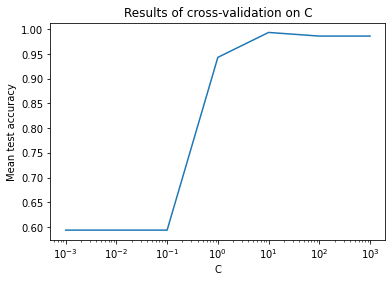

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/340 [00:00<?, ?it/s]

[[182  11]
 [  9 138]]
              precision    recall  f1-score   support

  Non-planar       0.95      0.94      0.95       193
      Planar       0.93      0.94      0.93       147

    accuracy                           0.94       340
   macro avg       0.94      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340


	### Score: 94.12% (precision for planar: 0.926 & non-planar: 0.953)

	### 10 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.5040
Function value obtained: -0.9937
Current minimum: -0.9937
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.7385
Function value obtained: -0.9880
Current minimum: -0.9937
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.5535
Function value obtained: -0.9880
Current minimum: -0.9937
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 5.5569
Function value obtained: -0.9987
Current minimum: -0.9987
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.4845
Function value obtained: -0.9851
Current minimum: -0.9987
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 5.7838
Function value obtained: -0.9886
Current minimum: -0.9987
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 5.7297
Function value obtained: -0.9915
Current minimum: -0.9987
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 5.7288
Function value obtained: -0.9934
Current minimum: -0.9987
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 5.5963
Function value obtained: -0.9877
Current minimum: -0.9987
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 5.5872
Function value obtained: -0.9940
Current minimum: -0.9987
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 5.7058
Function value obtained: -0.9978
Current minimum: -0.9987
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 5.6935
Function value obtained: -0.9914
Current minimum: -0.9987
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 5.8353
Function value obtained: -0.9940
Current minimum: -0.9987
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 5.4974
Function value obtained: -0.9949
Current minimum: -0.9987
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 5.7744
Function value obtained: -0.9934
Current minimum: -0.9987
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 5.7705
Function value obtained: -0.9940
Current minimum: -0.9987
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 5.6470
Function value obtained: -0.9911
Current minimum: -0.9987
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 5.6410
Function value obtained: -0.9898
Current minimum: -0.9987
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 5.8187
Function value obtained: -0.9956
Current minimum: -0.9987
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 5.7883
Function value obtained: -0.9917
Current minimum: -0.9987
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 5.7086
Function value obtained: -0.9930
Current minimum: -0.9987
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 5.5381
Function value obtained: -0.9886
Current minimum: -0.9987
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 5.6200
Function value obtained: -0.9943
Current minimum: -0.9987
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 6.0483
Function value obtained: -0.9946
Current minimum: -0.9987
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 5.7913
Function value obtained: -0.9889
Current minimum: -0.9987
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 5.9924
Function value obtained: -0.9908
Current minimum: -0.9987
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 5.9737
Function value obtained: -0.9940
Current minimum: -0.9987
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 5.8954
Function value obtained: -0.9880
Current minimum: -0.9987
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 5.6260
Function value obtained: -0.9911
Current minimum: -0.9987
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 5.6809
Function value obtained: -0.9959
Current minimum: -0.9987
Score  99.9% obtained for times [2.2611049519032744, 1.4702844700843367] and pulses [0.026535922110211836, 0.6775410914614636]


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 99.873% ± 0.889% for C=100.0


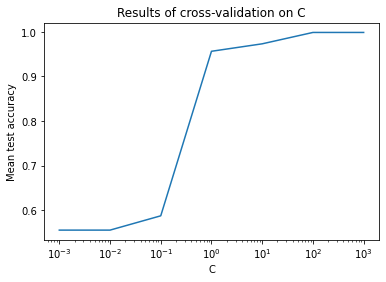

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/340 [00:00<?, ?it/s]

[[190   3]
 [  7 140]]
              precision    recall  f1-score   support

  Non-planar       0.96      0.98      0.97       193
      Planar       0.98      0.95      0.97       147

    accuracy                           0.97       340
   macro avg       0.97      0.97      0.97       340
weighted avg       0.97      0.97      0.97       340


	### Score: 97.06% (precision for planar: 0.979 & non-planar: 0.964)

	### 11 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.9298
Function value obtained: -0.9817
Current minimum: -0.9817
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.1925
Function value obtained: -0.9898
Current minimum: -0.9898
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.2067
Function value obtained: -0.9781
Current minimum: -0.9898
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.4166
Function value obtained: -0.9766
Current minimum: -0.9898
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.5754
Function value obtained: -0.9725
Current minimum: -0.9898
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 7.1611
Function value obtained: -0.9728
Current minimum: -0.9898
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 7.3198
Function value obtained: -0.9764
Current minimum: -0.9898
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 7.5640
Function value obtained: -0.9776
Current minimum: -0.9898
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 7.7465
Function value obtained: -0.9773
Current minimum: -0.9898
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 7.4329
Function value obtained: -0.9817
Current minimum: -0.9898
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 7.5789
Function value obtained: -0.9818
Current minimum: -0.9898
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 7.5087
Function value obtained: -0.9751
Current minimum: -0.9898
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 7.2440
Function value obtained: -0.9763
Current minimum: -0.9898
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 7.9706
Function value obtained: -0.9790
Current minimum: -0.9898
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 7.3264
Function value obtained: -0.9826
Current minimum: -0.9898
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 7.8133
Function value obtained: -0.9799
Current minimum: -0.9898
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 7.2685
Function value obtained: -0.9823
Current minimum: -0.9898
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 7.0568
Function value obtained: -0.9818
Current minimum: -0.9898
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 7.5972
Function value obtained: -0.9844
Current minimum: -0.9898
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 7.7806
Function value obtained: -0.9835
Current minimum: -0.9898
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.7850
Function value obtained: -0.9797
Current minimum: -0.9898
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 7.3368
Function value obtained: -0.9832
Current minimum: -0.9898
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 7.4270
Function value obtained: -0.9853
Current minimum: -0.9898
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.1537
Function value obtained: -0.9770
Current minimum: -0.9898
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 7.1512
Function value obtained: -0.9761
Current minimum: -0.9898
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 7.4882
Function value obtained: -0.9859
Current minimum: -0.9898
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 7.4288
Function value obtained: -0.9788
Current minimum: -0.9898
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 7.4137
Function value obtained: -0.9761
Current minimum: -0.9898
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 7.3128
Function value obtained: -0.9803
Current minimum: -0.9898
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 7.1715
Function value obtained: -0.9731
Current minimum: -0.9898
Score  99.0% obtained for times [2.0072722782968864, 2.931950520368011] and pulses [0.00223611048397554, 0.5155091395662144]


  0%|          | 0/334 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 98.985% ± 1.895% for C=1000.0


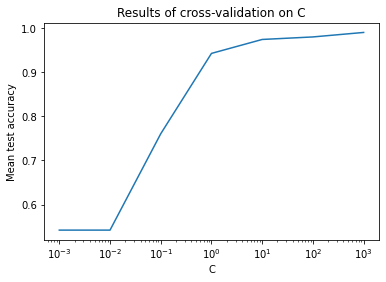

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/340 [00:00<?, ?it/s]

[[189   4]
 [ 12 135]]
              precision    recall  f1-score   support

  Non-planar       0.94      0.98      0.96       193
      Planar       0.97      0.92      0.94       147

    accuracy                           0.95       340
   macro avg       0.96      0.95      0.95       340
weighted avg       0.95      0.95      0.95       340


	### Score: 95.29% (precision for planar: 0.971 & non-planar: 0.940)

	### 12 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.5982
Function value obtained: -0.9911
Current minimum: -0.9911
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.5942
Function value obtained: -0.9937
Current minimum: -0.9937
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.9559
Function value obtained: -0.9824
Current minimum: -0.9937
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.4305
Function value obtained: -0.9931
Current minimum: -0.9937
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.5727
Function value obtained: -0.9853
Current minimum: -0.9937
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 10.6211
Function value obtained: -0.9900
Current minimum: -0.9937
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 11.0120
Function value obtained: -0.9888
Current minimum: -0.9937
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 9.8171
Function value obtained: -0.9911
Current minimum: -0.9937
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 10.0133
Function value obtained: -0.9882
Current minimum: -0.9937
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 10.5048
Function value obtained: -0.9845
Current minimum: -0.9937
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 10.8634
Function value obtained: -0.9868
Current minimum: -0.9937
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 9.7413
Function value obtained: -0.9882
Current minimum: -0.9937
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 10.6728
Function value obtained: -0.9937
Current minimum: -0.9937
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 10.9130
Function value obtained: -0.9911
Current minimum: -0.9937
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 10.0746
Function value obtained: -0.9775
Current minimum: -0.9937
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 10.4435
Function value obtained: -0.9850
Current minimum: -0.9937
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 10.9943
Function value obtained: -0.9882
Current minimum: -0.9937
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 10.5570
Function value obtained: -0.9960
Current minimum: -0.9960
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 10.7691
Function value obtained: -0.9945
Current minimum: -0.9960
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 11.9140
Function value obtained: -0.9908
Current minimum: -0.9960
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 10.7134
Function value obtained: -0.9960
Current minimum: -0.9960
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 11.6089
Function value obtained: -0.9740
Current minimum: -0.9960
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 10.2617
Function value obtained: -0.9960
Current minimum: -0.9960
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 10.2818
Function value obtained: -0.9948
Current minimum: -0.9960
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 11.0551
Function value obtained: -0.9893
Current minimum: -0.9960
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 11.7167
Function value obtained: -0.9928
Current minimum: -0.9960
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 10.5058
Function value obtained: -0.9960
Current minimum: -0.9960
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 10.6686
Function value obtained: -0.9937
Current minimum: -0.9960
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 11.0789
Function value obtained: -0.9879
Current minimum: -0.9960
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 10.2150
Function value obtained: -0.9925
Current minimum: -0.9960
Score  99.6% obtained for times [0.12309702656253987, 0.8797657738544018] and pulses [0.4431490800295147, 0.5326148489801928]


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 99.599% ± 1.281% for C=100.0


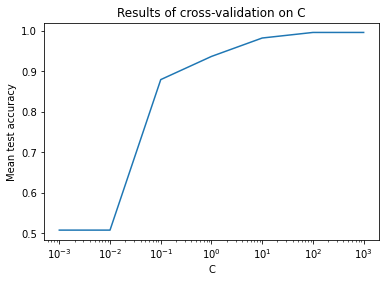

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/340 [00:00<?, ?it/s]

[[189   4]
 [  2 145]]
              precision    recall  f1-score   support

  Non-planar       0.99      0.98      0.98       193
      Planar       0.97      0.99      0.98       147

    accuracy                           0.98       340
   macro avg       0.98      0.98      0.98       340
weighted avg       0.98      0.98      0.98       340


	### Score: 98.24% (precision for planar: 0.973 & non-planar: 0.990)

	### 13 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 19.5141
Function value obtained: -0.9863
Current minimum: -0.9863
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.5929
Function value obtained: -0.9933
Current minimum: -0.9933
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 16.4026
Function value obtained: -0.9933
Current minimum: -0.9933
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 15.1774
Function value obtained: -0.9936
Current minimum: -0.9936
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 16.2064
Function value obtained: -0.9907
Current minimum: -0.9936
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 15.5489
Function value obtained: -0.9852
Current minimum: -0.9936
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 15.5104
Function value obtained: -0.9846
Current minimum: -0.9936
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 16.6384
Function value obtained: -0.9807
Current minimum: -0.9936
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 16.0847
Function value obtained: -0.9902
Current minimum: -0.9936
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 15.9357
Function value obtained: -0.9863
Current minimum: -0.9936
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 14.5104
Function value obtained: -0.9846
Current minimum: -0.9936
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 17.1163
Function value obtained: -0.9846
Current minimum: -0.9936
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 14.7941
Function value obtained: -0.9894
Current minimum: -0.9936
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 15.6363
Function value obtained: -0.9911
Current minimum: -0.9936
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 15.6429
Function value obtained: -0.9894
Current minimum: -0.9936
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 15.7421
Function value obtained: -0.9874
Current minimum: -0.9936
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 16.1579
Function value obtained: -0.9774
Current minimum: -0.9936
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 15.2904
Function value obtained: -0.9846
Current minimum: -0.9936
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 15.6576
Function value obtained: -0.9911
Current minimum: -0.9936
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 15.1723
Function value obtained: -0.9863
Current minimum: -0.9936
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 16.1857
Function value obtained: -0.9922
Current minimum: -0.9936
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 14.4271
Function value obtained: -0.9818
Current minimum: -0.9936
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 16.5470
Function value obtained: -0.9944
Current minimum: -0.9944
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 15.8643
Function value obtained: -0.9810
Current minimum: -0.9944
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 15.8072
Function value obtained: -0.9899
Current minimum: -0.9944
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 16.3765
Function value obtained: -0.9849
Current minimum: -0.9944
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 17.0907
Function value obtained: -0.9924
Current minimum: -0.9944
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 15.9728
Function value obtained: -0.9843
Current minimum: -0.9944
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 17.3091
Function value obtained: -0.9799
Current minimum: -0.9944
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 16.6846
Function value obtained: -0.9885
Current minimum: -0.9944
Score  99.4% obtained for times [1.0420654040615527, 2.7947690234215714] and pulses [0.12845290020217284, 0.990478120096492]


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 99.439% ± 1.256% for C=100.0


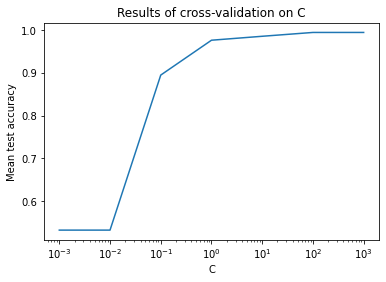

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/340 [00:00<?, ?it/s]

[[184   9]
 [  3 144]]
              precision    recall  f1-score   support

  Non-planar       0.98      0.95      0.97       193
      Planar       0.94      0.98      0.96       147

    accuracy                           0.96       340
   macro avg       0.96      0.97      0.96       340
weighted avg       0.97      0.96      0.96       340


	### Score: 96.47% (precision for planar: 0.941 & non-planar: 0.984)

	### 14 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 37.3299
Function value obtained: -0.9723
Current minimum: -0.9723
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 24.4908
Function value obtained: -0.9763
Current minimum: -0.9763
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 26.6541
Function value obtained: -0.9742
Current minimum: -0.9763
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 24.6182
Function value obtained: -0.9723
Current minimum: -0.9763
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 28.4229
Function value obtained: -0.9742
Current minimum: -0.9763
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 27.1265
Function value obtained: -0.9810
Current minimum: -0.9810
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 23.6984
Function value obtained: -0.9723
Current minimum: -0.9810
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 28.6846
Function value obtained: -0.9774
Current minimum: -0.9810
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 27.1453
Function value obtained: -0.9720
Current minimum: -0.9810
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 28.0669
Function value obtained: -0.9763
Current minimum: -0.9810
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 25.2571
Function value obtained: -0.9665
Current minimum: -0.9810
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 24.7651
Function value obtained: -0.9682
Current minimum: -0.9810
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 24.3604
Function value obtained: -0.9611
Current minimum: -0.9810
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 25.7755
Function value obtained: -0.9744
Current minimum: -0.9810
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 28.7125
Function value obtained: -0.9777
Current minimum: -0.9810
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 25.8225
Function value obtained: -0.9704
Current minimum: -0.9810
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 27.3227
Function value obtained: -0.9785
Current minimum: -0.9810
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 26.8576
Function value obtained: -0.9782
Current minimum: -0.9810
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 26.6392
Function value obtained: -0.9707
Current minimum: -0.9810
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 25.0315
Function value obtained: -0.9731
Current minimum: -0.9810
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 27.3853
Function value obtained: -0.9736
Current minimum: -0.9810
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 25.8841
Function value obtained: -0.9706
Current minimum: -0.9810
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 27.6638
Function value obtained: -0.9780
Current minimum: -0.9810
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 23.9463
Function value obtained: -0.9810
Current minimum: -0.9810
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 23.8056
Function value obtained: -0.9777
Current minimum: -0.9810
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 22.9175
Function value obtained: -0.9780
Current minimum: -0.9810
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 23.3002
Function value obtained: -0.9647
Current minimum: -0.9810
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 23.1802
Function value obtained: -0.9747
Current minimum: -0.9810
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 24.1258
Function value obtained: -0.9723
Current minimum: -0.9810
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 27.1822
Function value obtained: -0.9807
Current minimum: -0.9810
Score  98.1% obtained for times [0.3769209078729642, 0.4051450980475625] and pulses [0.1291721128058724, 0.12984524400414635]


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 98.095% ± 2.201% for C=10.0


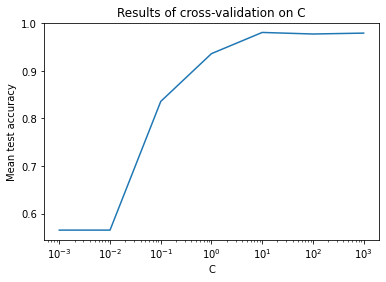

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/340 [00:00<?, ?it/s]

[[188   5]
 [  7 140]]
              precision    recall  f1-score   support

  Non-planar       0.96      0.97      0.97       193
      Planar       0.97      0.95      0.96       147

    accuracy                           0.96       340
   macro avg       0.96      0.96      0.96       340
weighted avg       0.96      0.96      0.96       340


	### Score: 96.47% (precision for planar: 0.966 & non-planar: 0.964)

	### 15 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 58.4289
Function value obtained: -0.9737
Current minimum: -0.9737
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 49.6876
Function value obtained: -0.9829
Current minimum: -0.9829
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 42.7908
Function value obtained: -0.9841
Current minimum: -0.9841
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 47.5043
Function value obtained: -0.9825
Current minimum: -0.9841
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 47.2900
Function value obtained: -0.9848
Current minimum: -0.9848
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 47.1624
Function value obtained: -0.9739
Current minimum: -0.9848
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 45.8803
Function value obtained: -0.9875
Current minimum: -0.9875
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 41.6504
Function value obtained: -0.9635
Current minimum: -0.9875
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 49.3132
Function value obtained: -0.9808
Current minimum: -0.9875
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 44.9359
Function value obtained: -0.9731
Current minimum: -0.9875
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 46.4599
Function value obtained: -0.9665
Current minimum: -0.9875
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 44.6708
Function value obtained: -0.9718
Current minimum: -0.9875
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 48.4176
Function value obtained: -0.9743
Current minimum: -0.9875
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 43.3511
Function value obtained: -0.9681
Current minimum: -0.9875
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 44.7590
Function value obtained: -0.9808
Current minimum: -0.9875
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 49.0137
Function value obtained: -0.9748
Current minimum: -0.9875
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 43.8068
Function value obtained: -0.9896
Current minimum: -0.9896
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 49.0506
Function value obtained: -0.9809
Current minimum: -0.9896
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 46.6698
Function value obtained: -0.9663
Current minimum: -0.9896
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 44.4073
Function value obtained: -0.9897
Current minimum: -0.9897
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 41.8745
Function value obtained: -0.9857
Current minimum: -0.9897
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 46.5451
Function value obtained: -0.9896
Current minimum: -0.9897
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 45.4810
Function value obtained: -0.9872
Current minimum: -0.9897
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 51.8448
Function value obtained: -0.9830
Current minimum: -0.9897
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 39.8103
Function value obtained: -0.9897
Current minimum: -0.9897
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 42.0251
Function value obtained: -0.9830
Current minimum: -0.9897
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 49.2113
Function value obtained: -0.9750
Current minimum: -0.9897
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 46.1707
Function value obtained: -0.9844
Current minimum: -0.9897
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 53.1172
Function value obtained: -0.9883
Current minimum: -0.9897
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 43.3144
Function value obtained: -0.9910
Current minimum: -0.9910
Score  99.1% obtained for times [1.8842336454283126, 2.5478385357220077] and pulses [0.5739086355707992, 0.0056045223258840435]


  0%|          | 0/376 [00:00<?, ?it/s]

  0%|          | 0/376 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 99.097% ± 1.462% for C=100.0


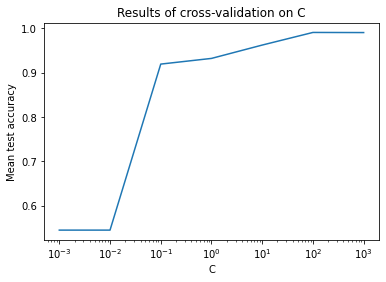

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/340 [00:00<?, ?it/s]

[[193   0]
 [  2 145]]
              precision    recall  f1-score   support

  Non-planar       0.99      1.00      0.99       193
      Planar       1.00      0.99      0.99       147

    accuracy                           0.99       340
   macro avg       0.99      0.99      0.99       340
weighted avg       0.99      0.99      0.99       340


	### Score: 99.41% (precision for planar: 1.000 & non-planar: 0.990)


In [89]:
bounds = [(0., 3.)] * 2 + [(0., 1.)] * 2
verbose = True
metric = 'precision'


scores, all_times, all_pulses = [], [], []
ns = range(5, 16)
N = 500

# 3 -> 6: 10 -> 40
# 7 -> 10: 25 -> 100
# 11 -> 15: 30 -> 150
# 16 -> 20: 10 -> 50
Ns = [10] * 4 + [25] * 4 + [30] * 5 + [10] * 5
test_graphs, test_targets = generate_graphs(range(3, 21), Ns, generator='binomial')

for n in tqdm(ns):
    if verbose: print(f"\n\t### {n} NODES ###")
    # Generate data
    # graphs, targets = generate_graphs([n], [N], generator='binomial')
    train_ns = list(range(5, n + 1))
    train_nbs = generate_nbs(3, n, N)
    graphs, targets = generate_graphs(train_ns, train_nbs, generator='binomial')
    observables_memoizer = Memoizer(observable)
    def get_score(param):
        """ 
        Uses above graphs, targets and observables_memoizer
        """
        middle = len(param)//2
        states = return_list_of_states(graphs, param[0:middle], param[middle::], evol='ising')
        energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable)
        matrix = return_js_matrix(energies)
        K = np.exp(-matrix)
        C_list = np.logspace(-3, 3, 7)

        param_grid = {'C': C_list}
        scoring = {'accuracy': make_scorer(accuracy_score),
                   'f1_score': make_scorer(f1_score, average='weighted')}

        skf = RepeatedStratifiedKFold(10, 10, random_state=47)
        estimator = svm.SVC(kernel='precomputed', random_state=76)
        grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                        cv=skf, refit=False, n_jobs=-1)
        result = grid_search.fit(K, targets).cv_results_
        return -np.max(result['mean_test_accuracy'])

    # Find optimized parameters
    opt_result = gp_minimize(
        get_score,
        bounds,
        acq_func='LCB',
        n_calls=30,
        n_initial_points=20,
        acq_optimizer='sampling',
        n_points=5000,
        kappa=4,
        n_jobs=-1,
        verbose=True
    )
    i_best = np.argmin(opt_result.func_vals)
    score = np.abs(opt_result.func_vals[i_best])
    times = opt_result.x_iters[i_best][:2]
    pulses = opt_result.x_iters[i_best][2:]
    if verbose:
        print(f"Score {score:6.1%} obtained for times {times} and pulses {pulses}")
    all_times.append(times)
    all_pulses.append(pulses)
    
    # Get trained model with found parameters
    model, energies_masses, energies = get_trained_model(times, pulses, graphs, targets, verbose=True)
    
    # Use model to predict on test data
    y_true, y_pred, score = predict(model, times, pulses, test_graphs, test_targets, energies_masses, energies, verbose=verbose)
    
    score_p, score_np = analyse_pred(y_true, y_pred, score, metric=metric, verbose=verbose)
    scores.append((score, score_p[metric], score_np[metric]))

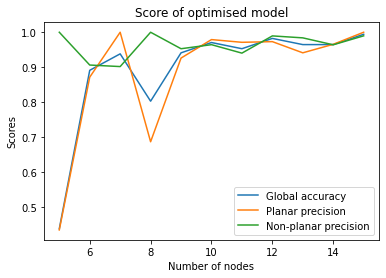

In [92]:
# Plot scores
pd.DataFrame(scores, columns=['Global accuracy', f'Planar {metric}', f'Non-planar {metric}'], index=ns).plot()
plt.ylabel('Scores')
plt.xlabel('Number of nodes')
plt.title('Score of optimised model')
plt.legend()
plt.show()

In [95]:
all_times

[[2.198561153646045, 0.014684713036138278],
 [2.4676397225495412, 2.96293795924532],
 [0.4899817138330954, 1.4829579881753834],
 [0.5771129615199415, 2.292142200134563],
 [0.9779238346676506, 2.5478794026624563],
 [2.2611049519032744, 1.4702844700843367],
 [2.0072722782968864, 2.931950520368011],
 [0.12309702656253987, 0.8797657738544018],
 [1.0420654040615527, 2.7947690234215714],
 [0.3769209078729642, 0.4051450980475625],
 [1.8842336454283126, 2.5478385357220077]]

In [96]:
all_pulses

[[0.8901955852106084, 0.6384686361728018],
 [0.3864894847756092, 0.5797149716685726],
 [0.9541907444713732, 0.4128271207320323],
 [0.22383522720465193, 0.23463742707343488],
 [0.3568167940949614, 0.680656591777041],
 [0.026535922110211836, 0.6775410914614636],
 [0.00223611048397554, 0.5155091395662144],
 [0.4431490800295147, 0.5326148489801928],
 [0.12845290020217284, 0.990478120096492],
 [0.1291721128058724, 0.12984524400414635],
 [0.5739086355707992, 0.0056045223258840435]]

In [39]:
# 1 iteration with N=1000 at n=5 takes 14s
# -> x30 = 7m
# 1 iteration with N=1000 at n=10 takes 29s
# -> x30 = 15m
# 1 iteration with N=1000 at n=15 takes more than 3min...
# -> x30 = 
# 1 iteration with N=1000 at n=8 takes 20s
# -> x30 = 10m
# 6h=360m / 30 
# Limit to 10: 7 + 9 + 9 + 10 + 13 + 15 = 63

In [40]:
# Do a loop: train until n predict until 15 and see what happens

# Train on different n

In [48]:
def generate_nbs(min_n, max_n, N_tot):
    # Both included
    nb_ns = max_n - min_n + 1
    ns = np.array(range(min_n, max_n + 1))
    return list(map(round, N_tot * ns / sum(ns)))

nbs = generate_nbs(3, 10, 1000)
nbs, sum(nbs)

([58, 77, 96, 115, 135, 154, 173, 192], 1000)

  0%|          | 0/11 [00:00<?, ?it/s]


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  80.0% planar in average
Generated graphs are at  80.0% planar in average

	# 2. Train model



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The

Accuracy: 100.000% ± 0.000% for C=1.0


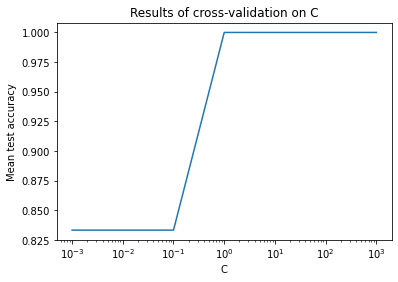

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/25 [00:00<?, ?it/s]

[[ 5  0]
 [ 0 20]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00         5
      Planar       1.00      1.00      1.00        20

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[197   0]
 [  0 803]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       197
      Planar       1.00      1.00      1.00       803

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 326]
 [  0 674]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       326
      Planar       0.67      1.00      0.81       674

    accuracy                           0.67      1000
   macro avg       0.34      0.50      0.40      1000
weighted avg       0.45      0.67      0.54      1000


	### Score: 67.40% (f1-score for planar: 0.805 & non-planar: 0.000)

	### 7 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 502]
 [ 98 400]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       502
      Planar       0.44      0.80      0.57       498

    accuracy                           0.40      1000
   macro avg       0.22      0.40      0.29      1000
weighted avg       0.22      0.40      0.28      1000


	### Score: 40.00% (f1-score for planar: 0.571 & non-planar: 0.000)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 420]
 [  0 580]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       420
      Planar       0.58      1.00      0.73       580

    accuracy                           0.58      1000
   macro avg       0.29      0.50      0.37      1000
weighted avg       0.34      0.58      0.43      1000


	### Score: 58.00% (f1-score for planar: 0.734 & non-planar: 0.000)

	### 9 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 483]
 [  0 517]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       483
      Planar       0.52      1.00      0.68       517

    accuracy                           0.52      1000
   macro avg       0.26      0.50      0.34      1000
weighted avg       0.27      0.52      0.35      1000


	### Score: 51.70% (f1-score for planar: 0.682 & non-planar: 0.000)

	### 10 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 495]
 [  0 505]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       495
      Planar       0.51      1.00      0.67       505

    accuracy                           0.51      1000
   macro avg       0.25      0.50      0.34      1000
weighted avg       0.26      0.51      0.34      1000


	### Score: 50.50% (f1-score for planar: 0.671 & non-planar: 0.000)

	### 11 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 606]
 [  0 394]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       606
      Planar       0.39      1.00      0.57       394

    accuracy                           0.39      1000
   macro avg       0.20      0.50      0.28      1000
weighted avg       0.16      0.39      0.22      1000


	### Score: 39.40% (f1-score for planar: 0.565 & non-planar: 0.000)

	### 12 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 576]
 [  0 424]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       576
      Planar       0.42      1.00      0.60       424

    accuracy                           0.42      1000
   macro avg       0.21      0.50      0.30      1000
weighted avg       0.18      0.42      0.25      1000


	### Score: 42.40% (f1-score for planar: 0.596 & non-planar: 0.000)

	### 13 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 631]
 [  0 369]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       631
      Planar       0.37      1.00      0.54       369

    accuracy                           0.37      1000
   macro avg       0.18      0.50      0.27      1000
weighted avg       0.14      0.37      0.20      1000


	### Score: 36.90% (f1-score for planar: 0.539 & non-planar: 0.000)

	### 14 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 709]
 [  0 291]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       709
      Planar       0.29      1.00      0.45       291

    accuracy                           0.29      1000
   macro avg       0.15      0.50      0.23      1000
weighted avg       0.08      0.29      0.13      1000


	### Score: 29.10% (f1-score for planar: 0.451 & non-planar: 0.000)

	### 15 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 685]
 [  0 315]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       685
      Planar       0.32      1.00      0.48       315

    accuracy                           0.32      1000
   macro avg       0.16      0.50      0.24      1000
weighted avg       0.10      0.32      0.15      1000


	### Score: 31.50% (f1-score for planar: 0.479 & non-planar: 0.000)


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

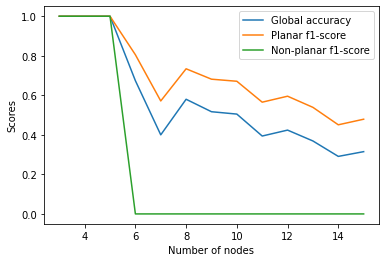


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  76.5% planar in average
Generated graphs with   6 nodes are at  63.6% planar in average
Generated graphs are at  69.2% planar in average

	# 2. Train model



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 97.417% ± 7.790% for C=10.0


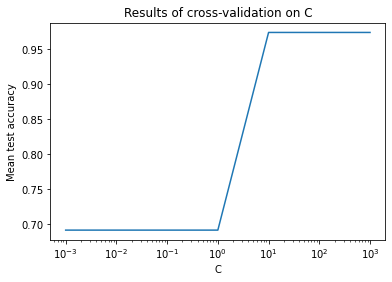

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/39 [00:00<?, ?it/s]

[[12  0]
 [ 0 27]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        12
      Planar       1.00      1.00      1.00        27

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[196   0]
 [  0 804]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       196
      Planar       1.00      1.00      1.00       804

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[328   0]
 [  0 672]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       328
      Planar       1.00      1.00      1.00       672

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[209 295]
 [ 96 400]]
              precision    recall  f1-score   support

  Non-planar       0.69      0.41      0.52       504
      Planar       0.58      0.81      0.67       496

    accuracy                           0.61      1000
   macro avg       0.63      0.61      0.59      1000
weighted avg       0.63      0.61      0.59      1000


	### Score: 60.90% (f1-score for planar: 0.672 & non-planar: 0.517)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[196 221]
 [ 87 496]]
              precision    recall  f1-score   support

  Non-planar       0.69      0.47      0.56       417
      Planar       0.69      0.85      0.76       583

    accuracy                           0.69      1000
   macro avg       0.69      0.66      0.66      1000
weighted avg       0.69      0.69      0.68      1000


	### Score: 69.20% (f1-score for planar: 0.763 & non-planar: 0.560)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[ 98 387]
 [  0 515]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.20      0.34       485
      Planar       0.57      1.00      0.73       515

    accuracy                           0.61      1000
   macro avg       0.79      0.60      0.53      1000
weighted avg       0.78      0.61      0.54      1000


	### Score: 61.30% (f1-score for planar: 0.727 & non-planar: 0.336)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[286 207]
 [  0 507]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.58      0.73       493
      Planar       0.71      1.00      0.83       507

    accuracy                           0.79      1000
   macro avg       0.86      0.79      0.78      1000
weighted avg       0.85      0.79      0.78      1000


	### Score: 79.30% (f1-score for planar: 0.830 & non-planar: 0.734)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[289 318]
 [  0 393]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.48      0.65       607
      Planar       0.55      1.00      0.71       393

    accuracy                           0.68      1000
   macro avg       0.78      0.74      0.68      1000
weighted avg       0.82      0.68      0.67      1000


	### Score: 68.20% (f1-score for planar: 0.712 & non-planar: 0.645)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[405 172]
 [ 17 406]]
              precision    recall  f1-score   support

  Non-planar       0.96      0.70      0.81       577
      Planar       0.70      0.96      0.81       423

    accuracy                           0.81      1000
   macro avg       0.83      0.83      0.81      1000
weighted avg       0.85      0.81      0.81      1000


	### Score: 81.10% (f1-score for planar: 0.811 & non-planar: 0.811)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[629   3]
 [ 11 357]]
              precision    recall  f1-score   support

  Non-planar       0.98      1.00      0.99       632
      Planar       0.99      0.97      0.98       368

    accuracy                           0.99      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 98.60% (f1-score for planar: 0.981 & non-planar: 0.989)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[685  22]
 [  0 293]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.97      0.98       707
      Planar       0.93      1.00      0.96       293

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 97.80% (f1-score for planar: 0.964 & non-planar: 0.984)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[624  58]
 [ 26 292]]
              precision    recall  f1-score   support

  Non-planar       0.96      0.91      0.94       682
      Planar       0.83      0.92      0.87       318

    accuracy                           0.92      1000
   macro avg       0.90      0.92      0.91      1000
weighted avg       0.92      0.92      0.92      1000


	### Score: 91.60% (f1-score for planar: 0.874 & non-planar: 0.937)


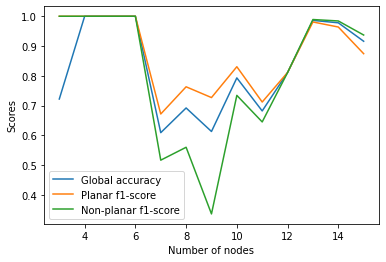


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  75.0% planar in average
Generated graphs with   6 nodes are at  68.8% planar in average
Generated graphs with   7 nodes are at  50.0% planar in average
Generated graphs are at  62.5% planar in average

	# 2. Train model



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 97.350% ± 7.432% for C=100.0


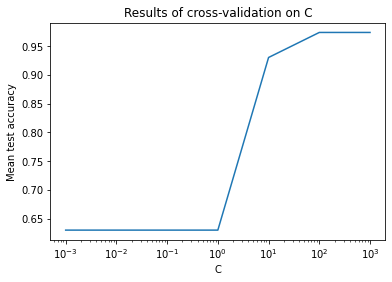

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/48 [00:00<?, ?it/s]

[[18  0]
 [ 0 30]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        18
      Planar       1.00      1.00      1.00        30

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[197   0]
 [  0 803]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       197
      Planar       1.00      1.00      1.00       803

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[327   0]
 [ 48 625]]
              precision    recall  f1-score   support

  Non-planar       0.87      1.00      0.93       327
      Planar       1.00      0.93      0.96       673

    accuracy                           0.95      1000
   macro avg       0.94      0.96      0.95      1000
weighted avg       0.96      0.95      0.95      1000


	### Score: 95.20% (f1-score for planar: 0.963 & non-planar: 0.932)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[365 141]
 [ 96 398]]
              precision    recall  f1-score   support

  Non-planar       0.79      0.72      0.75       506
      Planar       0.74      0.81      0.77       494

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000


	### Score: 76.30% (f1-score for planar: 0.771 & non-planar: 0.755)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[364  54]
 [ 96 486]]
              precision    recall  f1-score   support

  Non-planar       0.79      0.87      0.83       418
      Planar       0.90      0.84      0.87       582

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000


	### Score: 85.00% (f1-score for planar: 0.866 & non-planar: 0.829)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[445  38]
 [ 48 469]]
              precision    recall  f1-score   support

  Non-planar       0.90      0.92      0.91       483
      Planar       0.93      0.91      0.92       517

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000


	### Score: 91.40% (f1-score for planar: 0.916 & non-planar: 0.912)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[497   0]
 [ 75 428]]
              precision    recall  f1-score   support

  Non-planar       0.87      1.00      0.93       497
      Planar       1.00      0.85      0.92       503

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.92      1000
weighted avg       0.93      0.93      0.92      1000


	### Score: 92.50% (f1-score for planar: 0.919 & non-planar: 0.930)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[605   0]
 [101 294]]
              precision    recall  f1-score   support

  Non-planar       0.86      1.00      0.92       605
      Planar       1.00      0.74      0.85       395

    accuracy                           0.90      1000
   macro avg       0.93      0.87      0.89      1000
weighted avg       0.91      0.90      0.90      1000


	### Score: 89.90% (f1-score for planar: 0.853 & non-planar: 0.923)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[577   0]
 [116 307]]
              precision    recall  f1-score   support

  Non-planar       0.83      1.00      0.91       577
      Planar       1.00      0.73      0.84       423

    accuracy                           0.88      1000
   macro avg       0.92      0.86      0.87      1000
weighted avg       0.90      0.88      0.88      1000


	### Score: 88.40% (f1-score for planar: 0.841 & non-planar: 0.909)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[631   0]
 [108 261]]
              precision    recall  f1-score   support

  Non-planar       0.85      1.00      0.92       631
      Planar       1.00      0.71      0.83       369

    accuracy                           0.89      1000
   macro avg       0.93      0.85      0.87      1000
weighted avg       0.91      0.89      0.89      1000


	### Score: 89.20% (f1-score for planar: 0.829 & non-planar: 0.921)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[706   0]
 [ 25 269]]
              precision    recall  f1-score   support

  Non-planar       0.97      1.00      0.98       706
      Planar       1.00      0.91      0.96       294

    accuracy                           0.97      1000
   macro avg       0.98      0.96      0.97      1000
weighted avg       0.98      0.97      0.97      1000


	### Score: 97.50% (f1-score for planar: 0.956 & non-planar: 0.983)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[683   0]
 [ 55 262]]
              precision    recall  f1-score   support

  Non-planar       0.93      1.00      0.96       683
      Planar       1.00      0.83      0.91       317

    accuracy                           0.94      1000
   macro avg       0.96      0.91      0.93      1000
weighted avg       0.95      0.94      0.94      1000


	### Score: 94.50% (f1-score for planar: 0.905 & non-planar: 0.961)


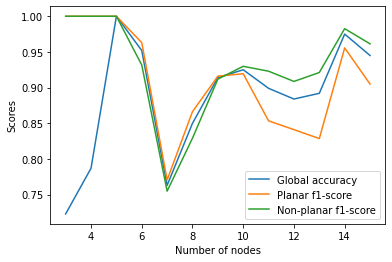


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  77.8% planar in average
Generated graphs with   6 nodes are at  50.0% planar in average
Generated graphs with   7 nodes are at  60.0% planar in average
Generated graphs with   8 nodes are at  44.4% planar in average
Generated graphs are at  55.6% planar in average

	# 2. Train model



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 87.333% ± 14.283% for C=100.0


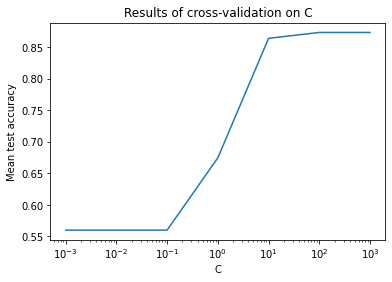

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/54 [00:00<?, ?it/s]

[[24  0]
 [ 0 30]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        24
      Planar       1.00      1.00      1.00        30

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[196   0]
 [  0 804]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       196
      Planar       1.00      1.00      1.00       804

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[241  87]
 [  0 672]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.73      0.85       328
      Planar       0.89      1.00      0.94       672

    accuracy                           0.91      1000
   macro avg       0.94      0.87      0.89      1000
weighted avg       0.92      0.91      0.91      1000


	### Score: 91.30% (f1-score for planar: 0.939 & non-planar: 0.847)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[363 142]
 [  0 495]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.72      0.84       505
      Planar       0.78      1.00      0.87       495

    accuracy                           0.86      1000
   macro avg       0.89      0.86      0.86      1000
weighted avg       0.89      0.86      0.86      1000


	### Score: 85.80% (f1-score for planar: 0.875 & non-planar: 0.836)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[390  29]
 [  9 572]]
              precision    recall  f1-score   support

  Non-planar       0.98      0.93      0.95       419
      Planar       0.95      0.98      0.97       581

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 96.20% (f1-score for planar: 0.968 & non-planar: 0.954)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[405  76]
 [ 48 471]]
              precision    recall  f1-score   support

  Non-planar       0.89      0.84      0.87       481
      Planar       0.86      0.91      0.88       519

    accuracy                           0.88      1000
   macro avg       0.88      0.87      0.88      1000
weighted avg       0.88      0.88      0.88      1000


	### Score: 87.60% (f1-score for planar: 0.884 & non-planar: 0.867)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[499   0]
 [ 75 426]]
              precision    recall  f1-score   support

  Non-planar       0.87      1.00      0.93       499
      Planar       1.00      0.85      0.92       501

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.92      1000
weighted avg       0.93      0.93      0.92      1000


	### Score: 92.50% (f1-score for planar: 0.919 & non-planar: 0.930)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[606   0]
 [ 93 301]]
              precision    recall  f1-score   support

  Non-planar       0.87      1.00      0.93       606
      Planar       1.00      0.76      0.87       394

    accuracy                           0.91      1000
   macro avg       0.93      0.88      0.90      1000
weighted avg       0.92      0.91      0.90      1000


	### Score: 90.70% (f1-score for planar: 0.866 & non-planar: 0.929)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[578   0]
 [126 296]]
              precision    recall  f1-score   support

  Non-planar       0.82      1.00      0.90       578
      Planar       1.00      0.70      0.82       422

    accuracy                           0.87      1000
   macro avg       0.91      0.85      0.86      1000
weighted avg       0.90      0.87      0.87      1000


	### Score: 87.40% (f1-score for planar: 0.825 & non-planar: 0.902)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[630   0]
 [127 243]]
              precision    recall  f1-score   support

  Non-planar       0.83      1.00      0.91       630
      Planar       1.00      0.66      0.79       370

    accuracy                           0.87      1000
   macro avg       0.92      0.83      0.85      1000
weighted avg       0.89      0.87      0.87      1000


	### Score: 87.30% (f1-score for planar: 0.793 & non-planar: 0.908)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[706   0]
 [ 26 268]]
              precision    recall  f1-score   support

  Non-planar       0.96      1.00      0.98       706
      Planar       1.00      0.91      0.95       294

    accuracy                           0.97      1000
   macro avg       0.98      0.96      0.97      1000
weighted avg       0.97      0.97      0.97      1000


	### Score: 97.40% (f1-score for planar: 0.954 & non-planar: 0.982)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[684   0]
 [ 62 254]]
              precision    recall  f1-score   support

  Non-planar       0.92      1.00      0.96       684
      Planar       1.00      0.80      0.89       316

    accuracy                           0.94      1000
   macro avg       0.96      0.90      0.92      1000
weighted avg       0.94      0.94      0.94      1000


	### Score: 93.80% (f1-score for planar: 0.891 & non-planar: 0.957)


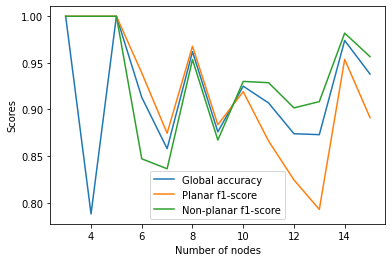


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  85.7% planar in average
Generated graphs with   6 nodes are at  50.0% planar in average
Generated graphs with   7 nodes are at  58.3% planar in average
Generated graphs with   8 nodes are at  35.7% planar in average
Generated graphs with   9 nodes are at  47.1% planar in average
Generated graphs are at  51.7% planar in average

	# 2. Train model



  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 94.167% ± 10.639% for C=100.0


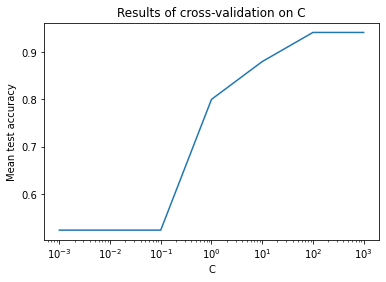

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/60 [00:00<?, ?it/s]

[[29  0]
 [ 0 31]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        29
      Planar       1.00      1.00      1.00        31

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[198   0]
 [ 37 765]]
              precision    recall  f1-score   support

  Non-planar       0.84      1.00      0.91       198
      Planar       1.00      0.95      0.98       802

    accuracy                           0.96      1000
   macro avg       0.92      0.98      0.95      1000
weighted avg       0.97      0.96      0.96      1000


	### Score: 96.30% (f1-score for planar: 0.976 & non-planar: 0.915)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[239  87]
 [152 522]]
              precision    recall  f1-score   support

  Non-planar       0.61      0.73      0.67       326
      Planar       0.86      0.77      0.81       674

    accuracy                           0.76      1000
   macro avg       0.73      0.75      0.74      1000
weighted avg       0.78      0.76      0.77      1000


	### Score: 76.10% (f1-score for planar: 0.814 & non-planar: 0.667)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[499   5]
 [  0 496]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.99      1.00       504
      Planar       0.99      1.00      0.99       496

    accuracy                           0.99      1000
   macro avg       1.00      1.00      0.99      1000
weighted avg       1.00      0.99      1.00      1000


	### Score: 99.50% (f1-score for planar: 0.995 & non-planar: 0.995)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[416   5]
 [ 10 569]]
              precision    recall  f1-score   support

  Non-planar       0.98      0.99      0.98       421
      Planar       0.99      0.98      0.99       579

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.98      0.99      1000


	### Score: 98.50% (f1-score for planar: 0.987 & non-planar: 0.982)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[480   0]
 [ 53 467]]
              precision    recall  f1-score   support

  Non-planar       0.90      1.00      0.95       480
      Planar       1.00      0.90      0.95       520

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 94.70% (f1-score for planar: 0.946 & non-planar: 0.948)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[502   0]
 [ 66 432]]
              precision    recall  f1-score   support

  Non-planar       0.88      1.00      0.94       502
      Planar       1.00      0.87      0.93       498

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000


	### Score: 93.40% (f1-score for planar: 0.929 & non-planar: 0.938)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[607   0]
 [104 289]]
              precision    recall  f1-score   support

  Non-planar       0.85      1.00      0.92       607
      Planar       1.00      0.74      0.85       393

    accuracy                           0.90      1000
   macro avg       0.93      0.87      0.88      1000
weighted avg       0.91      0.90      0.89      1000


	### Score: 89.60% (f1-score for planar: 0.848 & non-planar: 0.921)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[575   1]
 [145 279]]
              precision    recall  f1-score   support

  Non-planar       0.80      1.00      0.89       576
      Planar       1.00      0.66      0.79       424

    accuracy                           0.85      1000
   macro avg       0.90      0.83      0.84      1000
weighted avg       0.88      0.85      0.85      1000


	### Score: 85.40% (f1-score for planar: 0.793 & non-planar: 0.887)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[629   0]
 [133 238]]
              precision    recall  f1-score   support

  Non-planar       0.83      1.00      0.90       629
      Planar       1.00      0.64      0.78       371

    accuracy                           0.87      1000
   macro avg       0.91      0.82      0.84      1000
weighted avg       0.89      0.87      0.86      1000


	### Score: 86.70% (f1-score for planar: 0.782 & non-planar: 0.904)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[705   0]
 [ 44 251]]
              precision    recall  f1-score   support

  Non-planar       0.94      1.00      0.97       705
      Planar       1.00      0.85      0.92       295

    accuracy                           0.96      1000
   macro avg       0.97      0.93      0.94      1000
weighted avg       0.96      0.96      0.95      1000


	### Score: 95.60% (f1-score for planar: 0.919 & non-planar: 0.970)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[684   0]
 [ 62 254]]
              precision    recall  f1-score   support

  Non-planar       0.92      1.00      0.96       684
      Planar       1.00      0.80      0.89       316

    accuracy                           0.94      1000
   macro avg       0.96      0.90      0.92      1000
weighted avg       0.94      0.94      0.94      1000


	### Score: 93.80% (f1-score for planar: 0.891 & non-planar: 0.957)


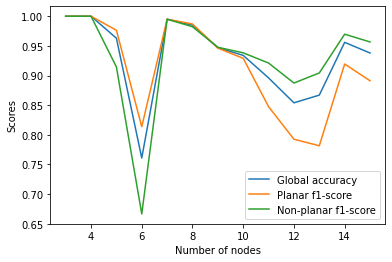


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at 100.0% planar in average
Generated graphs with   6 nodes are at  37.5% planar in average
Generated graphs with   7 nodes are at  60.0% planar in average
Generated graphs with   8 nodes are at  50.0% planar in average
Generated graphs with   9 nodes are at  46.2% planar in average
Generated graphs with  10 nodes are at  40.0% planar in average
Generated graphs are at  51.6% planar in average

	# 2. Train model



  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 91.286% ± 11.665% for C=100.0


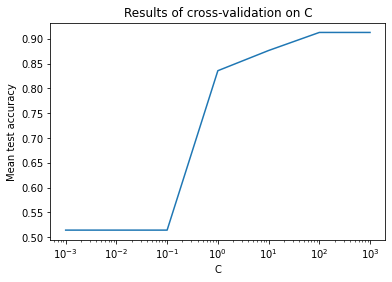

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/64 [00:00<?, ?it/s]

[[31  0]
 [ 0 33]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        31
      Planar       1.00      1.00      1.00        33

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 198]
 [ 37 765]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       198
      Planar       0.79      0.95      0.87       802

    accuracy                           0.77      1000
   macro avg       0.40      0.48      0.43      1000
weighted avg       0.64      0.77      0.70      1000


	### Score: 76.50% (f1-score for planar: 0.867 & non-planar: 0.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[239  87]
 [153 521]]
              precision    recall  f1-score   support

  Non-planar       0.61      0.73      0.67       326
      Planar       0.86      0.77      0.81       674

    accuracy                           0.76      1000
   macro avg       0.73      0.75      0.74      1000
weighted avg       0.78      0.76      0.76      1000


	### Score: 76.00% (f1-score for planar: 0.813 & non-planar: 0.666)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[497   8]
 [  0 495]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.98      0.99       505
      Planar       0.98      1.00      0.99       495

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 99.20% (f1-score for planar: 0.992 & non-planar: 0.992)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[331  89]
 [ 10 570]]
              precision    recall  f1-score   support

  Non-planar       0.97      0.79      0.87       420
      Planar       0.86      0.98      0.92       580

    accuracy                           0.90      1000
   macro avg       0.92      0.89      0.90      1000
weighted avg       0.91      0.90      0.90      1000


	### Score: 90.10% (f1-score for planar: 0.920 & non-planar: 0.870)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[480   0]
 [ 54 466]]
              precision    recall  f1-score   support

  Non-planar       0.90      1.00      0.95       480
      Planar       1.00      0.90      0.95       520

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 94.60% (f1-score for planar: 0.945 & non-planar: 0.947)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[501   0]
 [ 22 477]]
              precision    recall  f1-score   support

  Non-planar       0.96      1.00      0.98       501
      Planar       1.00      0.96      0.98       499

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 97.80% (f1-score for planar: 0.977 & non-planar: 0.979)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[608   0]
 [ 18 374]]
              precision    recall  f1-score   support

  Non-planar       0.97      1.00      0.99       608
      Planar       1.00      0.95      0.98       392

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 98.20% (f1-score for planar: 0.977 & non-planar: 0.985)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[562  14]
 [102 322]]
              precision    recall  f1-score   support

  Non-planar       0.85      0.98      0.91       576
      Planar       0.96      0.76      0.85       424

    accuracy                           0.88      1000
   macro avg       0.90      0.87      0.88      1000
weighted avg       0.89      0.88      0.88      1000


	### Score: 88.40% (f1-score for planar: 0.847 & non-planar: 0.906)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[629   0]
 [ 88 283]]
              precision    recall  f1-score   support

  Non-planar       0.88      1.00      0.93       629
      Planar       1.00      0.76      0.87       371

    accuracy                           0.91      1000
   macro avg       0.94      0.88      0.90      1000
weighted avg       0.92      0.91      0.91      1000


	### Score: 91.20% (f1-score for planar: 0.865 & non-planar: 0.935)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[704   0]
 [  7 289]]
              precision    recall  f1-score   support

  Non-planar       0.99      1.00      1.00       704
      Planar       1.00      0.98      0.99       296

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 99.30% (f1-score for planar: 0.988 & non-planar: 0.995)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[685   0]
 [ 29 286]]
              precision    recall  f1-score   support

  Non-planar       0.96      1.00      0.98       685
      Planar       1.00      0.91      0.95       315

    accuracy                           0.97      1000
   macro avg       0.98      0.95      0.97      1000
weighted avg       0.97      0.97      0.97      1000


	### Score: 97.10% (f1-score for planar: 0.952 & non-planar: 0.979)


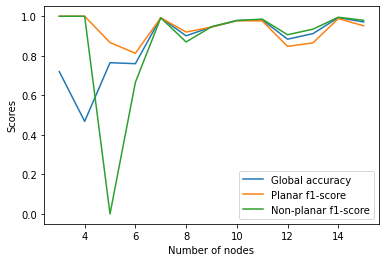


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at 100.0% planar in average
Generated graphs with   6 nodes are at  33.3% planar in average
Generated graphs with   7 nodes are at  37.5% planar in average
Generated graphs with   8 nodes are at  80.0% planar in average
Generated graphs with   9 nodes are at  36.4% planar in average
Generated graphs with  10 nodes are at  46.2% planar in average
Generated graphs with  11 nodes are at  28.6% planar in average
Generated graphs are at  47.8% planar in average

	# 2. Train model



  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 90.976% ± 11.360% for C=10.0


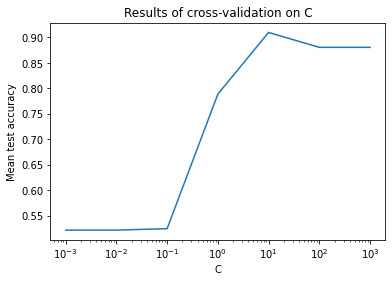

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/67 [00:00<?, ?it/s]

[[35  0]
 [ 2 30]]
              precision    recall  f1-score   support

  Non-planar       0.95      1.00      0.97        35
      Planar       1.00      0.94      0.97        32

    accuracy                           0.97        67
   macro avg       0.97      0.97      0.97        67
weighted avg       0.97      0.97      0.97        67


	### Score: 97.01% (f1-score for planar: 0.968 & non-planar: 0.972)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[198   0]
 [ 37 765]]
              precision    recall  f1-score   support

  Non-planar       0.84      1.00      0.91       198
      Planar       1.00      0.95      0.98       802

    accuracy                           0.96      1000
   macro avg       0.92      0.98      0.95      1000
weighted avg       0.97      0.96      0.96      1000


	### Score: 96.30% (f1-score for planar: 0.976 & non-planar: 0.915)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[239  87]
 [298 376]]
              precision    recall  f1-score   support

  Non-planar       0.45      0.73      0.55       326
      Planar       0.81      0.56      0.66       674

    accuracy                           0.61      1000
   macro avg       0.63      0.65      0.61      1000
weighted avg       0.69      0.61      0.63      1000


	### Score: 61.50% (f1-score for planar: 0.661 & non-planar: 0.554)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[458  46]
 [  0 496]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.91      0.95       504
      Planar       0.92      1.00      0.96       496

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000


	### Score: 95.40% (f1-score for planar: 0.956 & non-planar: 0.952)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[409  12]
 [ 42 537]]
              precision    recall  f1-score   support

  Non-planar       0.91      0.97      0.94       421
      Planar       0.98      0.93      0.95       579

    accuracy                           0.95      1000
   macro avg       0.94      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 94.60% (f1-score for planar: 0.952 & non-planar: 0.938)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[480   0]
 [ 65 455]]
              precision    recall  f1-score   support

  Non-planar       0.88      1.00      0.94       480
      Planar       1.00      0.88      0.93       520

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.93      1000
weighted avg       0.94      0.94      0.93      1000


	### Score: 93.50% (f1-score for planar: 0.933 & non-planar: 0.937)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[502   0]
 [ 40 458]]
              precision    recall  f1-score   support

  Non-planar       0.93      1.00      0.96       502
      Planar       1.00      0.92      0.96       498

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 96.00% (f1-score for planar: 0.958 & non-planar: 0.962)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[608   0]
 [ 38 354]]
              precision    recall  f1-score   support

  Non-planar       0.94      1.00      0.97       608
      Planar       1.00      0.90      0.95       392

    accuracy                           0.96      1000
   macro avg       0.97      0.95      0.96      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 96.20% (f1-score for planar: 0.949 & non-planar: 0.970)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[576   0]
 [135 289]]
              precision    recall  f1-score   support

  Non-planar       0.81      1.00      0.90       576
      Planar       1.00      0.68      0.81       424

    accuracy                           0.86      1000
   macro avg       0.91      0.84      0.85      1000
weighted avg       0.89      0.86      0.86      1000


	### Score: 86.50% (f1-score for planar: 0.811 & non-planar: 0.895)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[630   0]
 [111 259]]
              precision    recall  f1-score   support

  Non-planar       0.85      1.00      0.92       630
      Planar       1.00      0.70      0.82       370

    accuracy                           0.89      1000
   macro avg       0.93      0.85      0.87      1000
weighted avg       0.91      0.89      0.88      1000


	### Score: 88.90% (f1-score for planar: 0.824 & non-planar: 0.919)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[703   0]
 [ 28 269]]
              precision    recall  f1-score   support

  Non-planar       0.96      1.00      0.98       703
      Planar       1.00      0.91      0.95       297

    accuracy                           0.97      1000
   macro avg       0.98      0.95      0.97      1000
weighted avg       0.97      0.97      0.97      1000


	### Score: 97.20% (f1-score for planar: 0.951 & non-planar: 0.980)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[686   0]
 [ 60 254]]
              precision    recall  f1-score   support

  Non-planar       0.92      1.00      0.96       686
      Planar       1.00      0.81      0.89       314

    accuracy                           0.94      1000
   macro avg       0.96      0.90      0.93      1000
weighted avg       0.94      0.94      0.94      1000


	### Score: 94.00% (f1-score for planar: 0.894 & non-planar: 0.958)


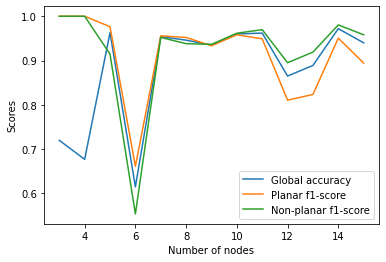


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at 100.0% planar in average
Generated graphs with   6 nodes are at  60.0% planar in average
Generated graphs with   7 nodes are at  42.9% planar in average
Generated graphs with   8 nodes are at  62.5% planar in average
Generated graphs with   9 nodes are at  44.4% planar in average
Generated graphs with  10 nodes are at  27.3% planar in average
Generated graphs with  11 nodes are at  41.7% planar in average
Generated graphs with  12 nodes are at  46.2% planar in average
Generated graphs are at  47.8% planar in average

	# 2. Train model



  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 93.571% ± 9.485% for C=1000.0


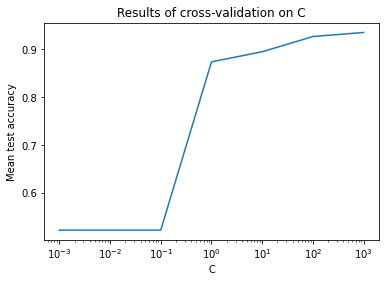

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/69 [00:00<?, ?it/s]

[[36  0]
 [ 0 33]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        36
      Planar       1.00      1.00      1.00        33

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 198]
 [  0 802]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       198
      Planar       0.80      1.00      0.89       802

    accuracy                           0.80      1000
   macro avg       0.40      0.50      0.45      1000
weighted avg       0.64      0.80      0.71      1000


	### Score: 80.20% (f1-score for planar: 0.890 & non-planar: 0.000)

	### 6 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[239  87]
 [  0 674]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.73      0.85       326
      Planar       0.89      1.00      0.94       674

    accuracy                           0.91      1000
   macro avg       0.94      0.87      0.89      1000
weighted avg       0.92      0.91      0.91      1000


	### Score: 91.30% (f1-score for planar: 0.939 & non-planar: 0.846)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[405  99]
 [  0 496]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.80      0.89       504
      Planar       0.83      1.00      0.91       496

    accuracy                           0.90      1000
   macro avg       0.92      0.90      0.90      1000
weighted avg       0.92      0.90      0.90      1000


	### Score: 90.10% (f1-score for planar: 0.909 & non-planar: 0.891)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[229 192]
 [  0 579]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.54      0.70       421
      Planar       0.75      1.00      0.86       579

    accuracy                           0.81      1000
   macro avg       0.88      0.77      0.78      1000
weighted avg       0.86      0.81      0.79      1000


	### Score: 80.80% (f1-score for planar: 0.858 & non-planar: 0.705)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[415  65]
 [  0 520]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.86      0.93       480
      Planar       0.89      1.00      0.94       520

    accuracy                           0.94      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.94      0.93      1000


	### Score: 93.50% (f1-score for planar: 0.941 & non-planar: 0.927)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[451  51]
 [  0 498]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.90      0.95       502
      Planar       0.91      1.00      0.95       498

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 94.90% (f1-score for planar: 0.951 & non-planar: 0.946)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[591  17]
 [  0 392]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.97      0.99       608
      Planar       0.96      1.00      0.98       392

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 98.30% (f1-score for planar: 0.979 & non-planar: 0.986)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[576   0]
 [ 21 403]]
              precision    recall  f1-score   support

  Non-planar       0.96      1.00      0.98       576
      Planar       1.00      0.95      0.97       424

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 97.90% (f1-score for planar: 0.975 & non-planar: 0.982)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[615  15]
 [ 69 301]]
              precision    recall  f1-score   support

  Non-planar       0.90      0.98      0.94       630
      Planar       0.95      0.81      0.88       370

    accuracy                           0.92      1000
   macro avg       0.93      0.89      0.91      1000
weighted avg       0.92      0.92      0.91      1000


	### Score: 91.60% (f1-score for planar: 0.878 & non-planar: 0.936)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[698   5]
 [  0 297]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.99      1.00       703
      Planar       0.98      1.00      0.99       297

    accuracy                           0.99      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       1.00      0.99      1.00      1000


	### Score: 99.50% (f1-score for planar: 0.992 & non-planar: 0.996)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[686   0]
 [ 13 301]]
              precision    recall  f1-score   support

  Non-planar       0.98      1.00      0.99       686
      Planar       1.00      0.96      0.98       314

    accuracy                           0.99      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 98.70% (f1-score for planar: 0.979 & non-planar: 0.991)


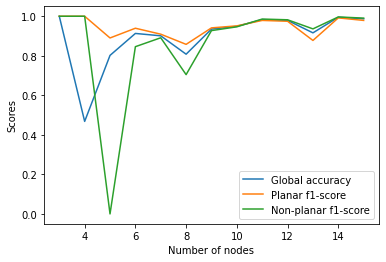


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at 100.0% planar in average
Generated graphs with   6 nodes are at  80.0% planar in average
Generated graphs with   7 nodes are at  33.3% planar in average
Generated graphs with   8 nodes are at  42.9% planar in average
Generated graphs with   9 nodes are at  75.0% planar in average
Generated graphs with  10 nodes are at  33.3% planar in average
Generated graphs with  11 nodes are at  20.0% planar in average
Generated graphs with  12 nodes are at  36.4% planar in average
Generated graphs with  13 nodes are at  41.7% planar in average
Generated graphs are at  45.1% planar in average

	# 2. Train model



  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 89.625% ± 9.980% for C=100.0


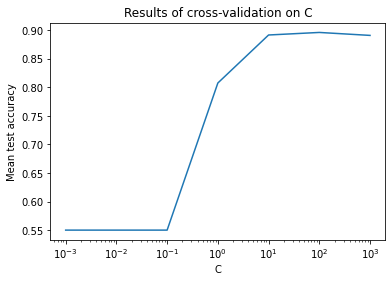

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/71 [00:00<?, ?it/s]

[[38  1]
 [ 0 32]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.97      0.99        39
      Planar       0.97      1.00      0.98        32

    accuracy                           0.99        71
   macro avg       0.98      0.99      0.99        71
weighted avg       0.99      0.99      0.99        71


	### Score: 98.59% (f1-score for planar: 0.985 & non-planar: 0.987)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 197]
 [  0 803]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       197
      Planar       0.80      1.00      0.89       803

    accuracy                           0.80      1000
   macro avg       0.40      0.50      0.45      1000
weighted avg       0.64      0.80      0.72      1000


	### Score: 80.30% (f1-score for planar: 0.891 & non-planar: 0.000)

	### 6 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[238  86]
 [  0 676]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.73      0.85       324
      Planar       0.89      1.00      0.94       676

    accuracy                           0.91      1000
   macro avg       0.94      0.87      0.89      1000
weighted avg       0.92      0.91      0.91      1000


	### Score: 91.40% (f1-score for planar: 0.940 & non-planar: 0.847)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[384 119]
 [  0 497]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.76      0.87       503
      Planar       0.81      1.00      0.89       497

    accuracy                           0.88      1000
   macro avg       0.90      0.88      0.88      1000
weighted avg       0.90      0.88      0.88      1000


	### Score: 88.10% (f1-score for planar: 0.893 & non-planar: 0.866)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[311 111]
 [  0 578]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.74      0.85       422
      Planar       0.84      1.00      0.91       578

    accuracy                           0.89      1000
   macro avg       0.92      0.87      0.88      1000
weighted avg       0.91      0.89      0.89      1000


	### Score: 88.90% (f1-score for planar: 0.912 & non-planar: 0.849)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[472   8]
 [  0 520]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.98      0.99       480
      Planar       0.98      1.00      0.99       520

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 99.20% (f1-score for planar: 0.992 & non-planar: 0.992)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[454  48]
 [  0 498]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.90      0.95       502
      Planar       0.91      1.00      0.95       498

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000


	### Score: 95.20% (f1-score for planar: 0.954 & non-planar: 0.950)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[554  54]
 [  0 392]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.91      0.95       608
      Planar       0.88      1.00      0.94       392

    accuracy                           0.95      1000
   macro avg       0.94      0.96      0.94      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 94.60% (f1-score for planar: 0.936 & non-planar: 0.954)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[564  12]
 [  0 424]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.98      0.99       576
      Planar       0.97      1.00      0.99       424

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 98.80% (f1-score for planar: 0.986 & non-planar: 0.989)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[611  19]
 [  0 370]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.97      0.98       630
      Planar       0.95      1.00      0.97       370

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 98.10% (f1-score for planar: 0.975 & non-planar: 0.985)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[663  38]
 [  0 299]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.95      0.97       701
      Planar       0.89      1.00      0.94       299

    accuracy                           0.96      1000
   macro avg       0.94      0.97      0.96      1000
weighted avg       0.97      0.96      0.96      1000


	### Score: 96.20% (f1-score for planar: 0.940 & non-planar: 0.972)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[678  10]
 [  0 312]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.99      0.99       688
      Planar       0.97      1.00      0.98       312

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 99.00% (f1-score for planar: 0.984 & non-planar: 0.993)


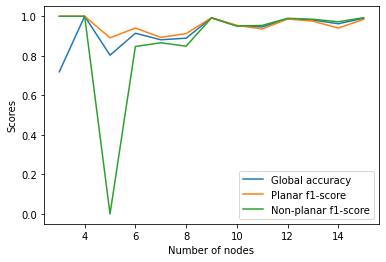


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at 100.0% planar in average
Generated graphs with   6 nodes are at  75.0% planar in average
Generated graphs with   7 nodes are at  20.0% planar in average
Generated graphs with   8 nodes are at  50.0% planar in average
Generated graphs with   9 nodes are at  85.7% planar in average
Generated graphs with  10 nodes are at  25.0% planar in average
Generated graphs with  11 nodes are at  22.2% planar in average
Generated graphs with  12 nodes are at  40.0% planar in average
Generated graphs with  13 nodes are at  18.2% planar in average
Generated graphs with  14 nodes are at  41.7% planar in average
Generated graphs are at  41.3% planar in average

	# 2. Train model



  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 92.518% ± 9.363% for C=10.0


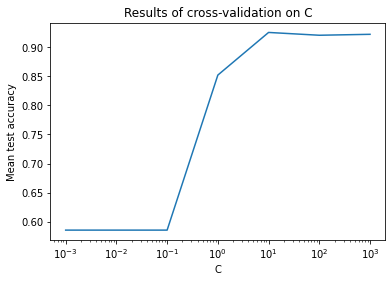

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/75 [00:00<?, ?it/s]

[[44  0]
 [ 3 28]]
              precision    recall  f1-score   support

  Non-planar       0.94      1.00      0.97        44
      Planar       1.00      0.90      0.95        31

    accuracy                           0.96        75
   macro avg       0.97      0.95      0.96        75
weighted avg       0.96      0.96      0.96        75


	### Score: 96.00% (f1-score for planar: 0.949 & non-planar: 0.967)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 197]
 [  0 803]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       197
      Planar       0.80      1.00      0.89       803

    accuracy                           0.80      1000
   macro avg       0.40      0.50      0.45      1000
weighted avg       0.64      0.80      0.72      1000


	### Score: 80.30% (f1-score for planar: 0.891 & non-planar: 0.000)

	### 6 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[214 110]
 [  0 676]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.66      0.80       324
      Planar       0.86      1.00      0.92       676

    accuracy                           0.89      1000
   macro avg       0.93      0.83      0.86      1000
weighted avg       0.91      0.89      0.88      1000


	### Score: 89.00% (f1-score for planar: 0.925 & non-planar: 0.796)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[243 260]
 [  0 497]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.48      0.65       503
      Planar       0.66      1.00      0.79       497

    accuracy                           0.74      1000
   macro avg       0.83      0.74      0.72      1000
weighted avg       0.83      0.74      0.72      1000


	### Score: 74.00% (f1-score for planar: 0.793 & non-planar: 0.651)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[289 133]
 [ 33 545]]
              precision    recall  f1-score   support

  Non-planar       0.90      0.68      0.78       422
      Planar       0.80      0.94      0.87       578

    accuracy                           0.83      1000
   macro avg       0.85      0.81      0.82      1000
weighted avg       0.84      0.83      0.83      1000


	### Score: 83.40% (f1-score for planar: 0.868 & non-planar: 0.777)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[479   0]
 [ 19 502]]
              precision    recall  f1-score   support

  Non-planar       0.96      1.00      0.98       479
      Planar       1.00      0.96      0.98       521

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 98.10% (f1-score for planar: 0.981 & non-planar: 0.981)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[503   0]
 [ 19 478]]
              precision    recall  f1-score   support

  Non-planar       0.96      1.00      0.98       503
      Planar       1.00      0.96      0.98       497

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 98.10% (f1-score for planar: 0.981 & non-planar: 0.981)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[582  25]
 [ 18 375]]
              precision    recall  f1-score   support

  Non-planar       0.97      0.96      0.96       607
      Planar       0.94      0.95      0.95       393

    accuracy                           0.96      1000
   macro avg       0.95      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 95.70% (f1-score for planar: 0.946 & non-planar: 0.964)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[578   0]
 [111 311]]
              precision    recall  f1-score   support

  Non-planar       0.84      1.00      0.91       578
      Planar       1.00      0.74      0.85       422

    accuracy                           0.89      1000
   macro avg       0.92      0.87      0.88      1000
weighted avg       0.91      0.89      0.89      1000


	### Score: 88.90% (f1-score for planar: 0.849 & non-planar: 0.912)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[630   0]
 [ 89 281]]
              precision    recall  f1-score   support

  Non-planar       0.88      1.00      0.93       630
      Planar       1.00      0.76      0.86       370

    accuracy                           0.91      1000
   macro avg       0.94      0.88      0.90      1000
weighted avg       0.92      0.91      0.91      1000


	### Score: 91.10% (f1-score for planar: 0.863 & non-planar: 0.934)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[701   0]
 [ 15 284]]
              precision    recall  f1-score   support

  Non-planar       0.98      1.00      0.99       701
      Planar       1.00      0.95      0.97       299

    accuracy                           0.98      1000
   macro avg       0.99      0.97      0.98      1000
weighted avg       0.99      0.98      0.98      1000


	### Score: 98.50% (f1-score for planar: 0.974 & non-planar: 0.989)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[687   0]
 [ 45 268]]
              precision    recall  f1-score   support

  Non-planar       0.94      1.00      0.97       687
      Planar       1.00      0.86      0.92       313

    accuracy                           0.95      1000
   macro avg       0.97      0.93      0.95      1000
weighted avg       0.96      0.95      0.95      1000


	### Score: 95.50% (f1-score for planar: 0.923 & non-planar: 0.968)


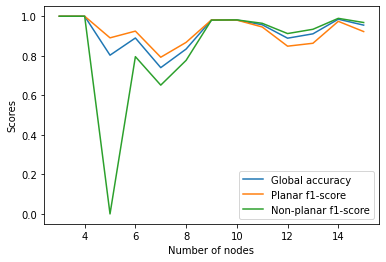


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at 100.0% planar in average
Generated graphs with   6 nodes are at 100.0% planar in average
Generated graphs with   7 nodes are at  25.0% planar in average
Generated graphs with   8 nodes are at  40.0% planar in average
Generated graphs with   9 nodes are at  50.0% planar in average
Generated graphs with  10 nodes are at  71.4% planar in average
Generated graphs with  11 nodes are at  37.5% planar in average
Generated graphs with  12 nodes are at   0.0% planar in average
Generated graphs with  13 nodes are at  44.4% planar in average
Generated graphs with  14 nodes are at  20.0% planar in average
Generated graphs with  15 nodes are at  36.4% planar in average
Generated graphs are at  40.0% planar in average

	# 2. Train model



  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 94.179% ± 8.390% for C=10.0


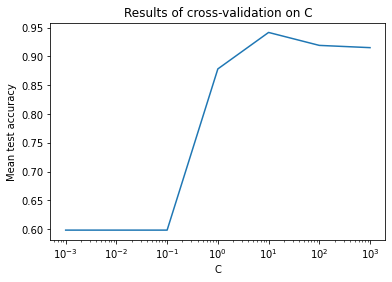

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/75 [00:00<?, ?it/s]

[[44  1]
 [ 1 29]]
              precision    recall  f1-score   support

  Non-planar       0.98      0.98      0.98        45
      Planar       0.97      0.97      0.97        30

    accuracy                           0.97        75
   macro avg       0.97      0.97      0.97        75
weighted avg       0.97      0.97      0.97        75


	### Score: 97.33% (f1-score for planar: 0.967 & non-planar: 0.978)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 197]
 [  0 803]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       197
      Planar       0.80      1.00      0.89       803

    accuracy                           0.80      1000
   macro avg       0.40      0.50      0.45      1000
weighted avg       0.64      0.80      0.72      1000


	### Score: 80.30% (f1-score for planar: 0.891 & non-planar: 0.000)

	### 6 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[214 110]
 [  0 676]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.66      0.80       324
      Planar       0.86      1.00      0.92       676

    accuracy                           0.89      1000
   macro avg       0.93      0.83      0.86      1000
weighted avg       0.91      0.89      0.88      1000


	### Score: 89.00% (f1-score for planar: 0.925 & non-planar: 0.796)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[147 356]
 [  0 497]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.29      0.45       503
      Planar       0.58      1.00      0.74       497

    accuracy                           0.64      1000
   macro avg       0.79      0.65      0.59      1000
weighted avg       0.79      0.64      0.59      1000


	### Score: 64.40% (f1-score for planar: 0.736 & non-planar: 0.452)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[203 219]
 [ 33 545]]
              precision    recall  f1-score   support

  Non-planar       0.86      0.48      0.62       422
      Planar       0.71      0.94      0.81       578

    accuracy                           0.75      1000
   macro avg       0.79      0.71      0.71      1000
weighted avg       0.78      0.75      0.73      1000


	### Score: 74.80% (f1-score for planar: 0.812 & non-planar: 0.617)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[475   4]
 [  0 521]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.99      1.00       479
      Planar       0.99      1.00      1.00       521

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 99.60% (f1-score for planar: 0.996 & non-planar: 0.996)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[394 109]
 [ 19 478]]
              precision    recall  f1-score   support

  Non-planar       0.95      0.78      0.86       503
      Planar       0.81      0.96      0.88       497

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000


	### Score: 87.20% (f1-score for planar: 0.882 & non-planar: 0.860)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[595  12]
 [  6 387]]
              precision    recall  f1-score   support

  Non-planar       0.99      0.98      0.99       607
      Planar       0.97      0.98      0.98       393

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 98.20% (f1-score for planar: 0.977 & non-planar: 0.985)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[575   3]
 [104 318]]
              precision    recall  f1-score   support

  Non-planar       0.85      0.99      0.91       578
      Planar       0.99      0.75      0.86       422

    accuracy                           0.89      1000
   macro avg       0.92      0.87      0.89      1000
weighted avg       0.91      0.89      0.89      1000


	### Score: 89.30% (f1-score for planar: 0.856 & non-planar: 0.915)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[630   0]
 [ 87 283]]
              precision    recall  f1-score   support

  Non-planar       0.88      1.00      0.94       630
      Planar       1.00      0.76      0.87       370

    accuracy                           0.91      1000
   macro avg       0.94      0.88      0.90      1000
weighted avg       0.92      0.91      0.91      1000


	### Score: 91.30% (f1-score for planar: 0.867 & non-planar: 0.935)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[687  14]
 [  8 291]]
              precision    recall  f1-score   support

  Non-planar       0.99      0.98      0.98       701
      Planar       0.95      0.97      0.96       299

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 97.80% (f1-score for planar: 0.964 & non-planar: 0.984)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[687   0]
 [ 22 291]]
              precision    recall  f1-score   support

  Non-planar       0.97      1.00      0.98       687
      Planar       1.00      0.93      0.96       313

    accuracy                           0.98      1000
   macro avg       0.98      0.96      0.97      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 97.80% (f1-score for planar: 0.964 & non-planar: 0.984)


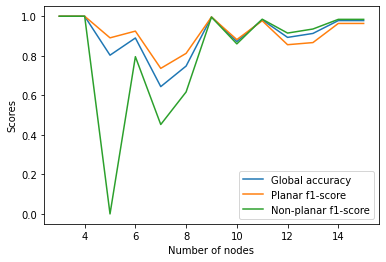

In [74]:
from qplanarity import test_suite

times = [2.1, 1.6]
pulses = [0.2, 0.1]
train_ns = range(3, 11)
train_nbs = 2 * [50] + 3 * [100] + 3 * [200]
generator = 'binomial'
metric = 'f1-score'
N = 100

scores = []
max_ns = range(5, 16)
test_ramping_max_n = 16
for max_n in tqdm(max_ns):
    train_ns = list(range(5, max_n + 1))
    train_nbs = generate_nbs(3, max_n, N)
    scores_loop = test_suite(times, pulses, train_ns, train_nbs, generator, seed=21, metric=metric, test_big=False, test_ramping_max_n=test_ramping_max_n)
    scores.append(scores_loop)

In [75]:
scores

[[(1.0, 1, 1),
  (1.0, 1, 1),
  (1.0, 1.0, 1.0),
  (0.674, 0.8052568697729989, 0.0),
  (0.4, 0.5714285714285714, 0.0),
  (0.58, 0.7341772151898733, 0.0),
  (0.517, 0.6816084377059988, 0.0),
  (0.505, 0.6710963455149502, 0.0),
  (0.394, 0.5652797704447633, 0.0),
  (0.424, 0.5955056179775281, 0.0),
  (0.369, 0.5390796201607012, 0.0),
  (0.291, 0.45081332300542215, 0.0),
  (0.315, 0.47908745247148293, 0.0)],
 [(0.722, 1, 1),
  (1.0, 1, 1),
  (1.0, 1.0, 1.0),
  (1.0, 1.0, 1.0),
  (0.609, 0.6717044500419814, 0.5166872682323858),
  (0.692, 0.7630769230769231, 0.56),
  (0.613, 0.7268877911079746, 0.33619210977701547),
  (0.793, 0.8304668304668305, 0.7342747111681643),
  (0.682, 0.7119565217391304, 0.6450892857142857),
  (0.811, 0.8111888111888111, 0.8108108108108107),
  (0.986, 0.9807692307692308, 0.988993710691824),
  (0.978, 0.9638157894736842, 0.9841954022988506),
  (0.916, 0.874251497005988, 0.9369369369369368)],
 [(0.723, 1, 1),
  (0.787, 1, 1),
  (1.0, 1.0, 1.0),
  (0.952, 0.96302003081

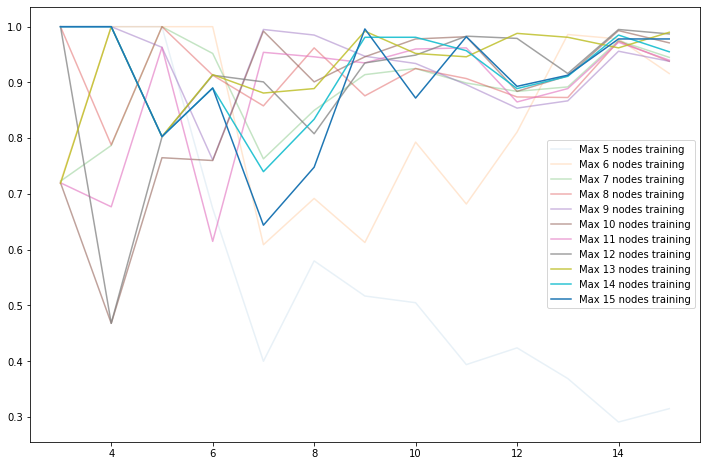

In [81]:
plt.figure(figsize=(12, 8))
for n, all_scores_n in zip(max_ns, scores):
    scores_n = np.array(all_scores_n)[:, 0]
    plt.plot(list(range(3, test_ramping_max_n)), scores_n, label=f"Max {n} nodes training", alpha=0.1 + 0.9 * (n - min(max_ns)) / (max(max_ns) - min(max_ns)))
plt.legend()
plt.show()